# Predicting Liver Disease — ML & DL Ensembles (Voting, Blending)
**Author:** murtaza  
**Dataset:** Already extended_liver_dataset.csv (n=5,000)  
**Goal:** Build, compare, and ensemble top models to predict `Diagnosis`.

**Highlights**
- Models: LR, RF, XGBoost, SVM (RBF), DNN
- Ensembles: Voting (RF+XGB), Blending (RF+XGB+SVM)
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC
- Extras: Feature importance, calibrated probabilities, threshold tuning

---

Now you’ll get:

5 base models fully compared.

Two hybrid ensembles (MLP+RF, MLP+XGB) with metrics,

 confusion matrices, ROC, PR curves, and bar charts.

Results are clean and ready for Colab presentation.

## STEP 1 — SETUP & DATA PREP
What this cell does:

1) Imports, config, and reproducibility

2) Load CSV and quick sanity checks

3) Split into train/test

4) Create scaled copies for models that need scaling (LR, SVM, DNN)

In [ ]:
# -------- Config --------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
SEED = 42
TEST_SIZE = 0.20
CSV_PATH = "\Liver_disease_data.csv"   # <-- change if needed


In [ ]:
# -------- Imports --------
import os, random, numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

### EDA — Extended Liver Dataset


In [ ]:
# Style for aesthetics
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 5)

# 1) Load dataset
df = pd.read_csv("\Liver_disease_data.csv")

# Quick overview
display(df.head())

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58.0,0.0,35.857584,17.272828,0.0,1.0,0.658940,0.0,0.0,42.734240,1
1,71.0,1.0,30.732470,2.201266,0.0,1.0,1.670557,1.0,0.0,67.309822,1
2,48.0,0.0,19.971407,18.500944,0.0,0.0,9.928308,0.0,0.0,63.738956,0
3,34.0,1.0,16.615417,12.632870,0.0,0.0,5.630129,0.0,0.0,64.555873,1
4,62.0,1.0,16.065830,1.087815,0.0,1.0,3.566218,1.0,0.0,77.868689,1


In [ ]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,50.189309,17.589267,18.419187,35.515129,50.202953,66.000000,81.590769
Gender,5000.0,0.466241,0.498776,-0.034388,0.000000,0.013540,1.000000,1.041769
BMI,5000.0,27.501471,7.192929,14.669797,21.091665,27.607620,33.789192,40.231662
AlcoholConsumption,5000.0,9.624500,5.723076,-0.320647,4.717671,9.404865,14.631649,20.375899
Smoking,5000.0,0.268507,0.443466,-0.034686,0.000000,0.000000,0.987914,1.030765
GeneticRisk,5000.0,0.491781,0.654816,-0.063303,0.000000,0.012822,1.000000,2.054249
PhysicalActivity,5000.0,4.960940,2.836388,-0.175164,2.624183,4.932781,7.339209,10.128208
Diabetes,5000.0,0.139494,0.346626,-0.033660,-0.000953,0.000000,0.007899,1.025043
Hypertension,5000.0,0.143403,0.350956,-0.034224,-0.001222,0.000000,0.008343,1.024407
LiverFunctionTest,5000.0,59.247227,22.812356,19.494050,39.850664,58.555081,78.315399,100.984604


In [ ]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 Age                   0
Gender                0
BMI                   0
AlcoholConsumption    0
Smoking               0
GeneticRisk           0
PhysicalActivity      0
Diabetes              0
Hypertension          0
LiverFunctionTest     0
Diagnosis             0
dtype: int64


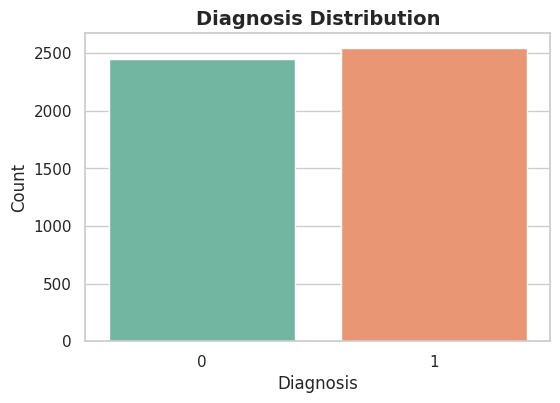

In [ ]:
# -------------------------
# 2) Target variable distribution
# -------------------------
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Diagnosis", hue="Diagnosis", palette="Set2", legend=False)
plt.title("Diagnosis Distribution", fontsize=14, weight='bold')
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

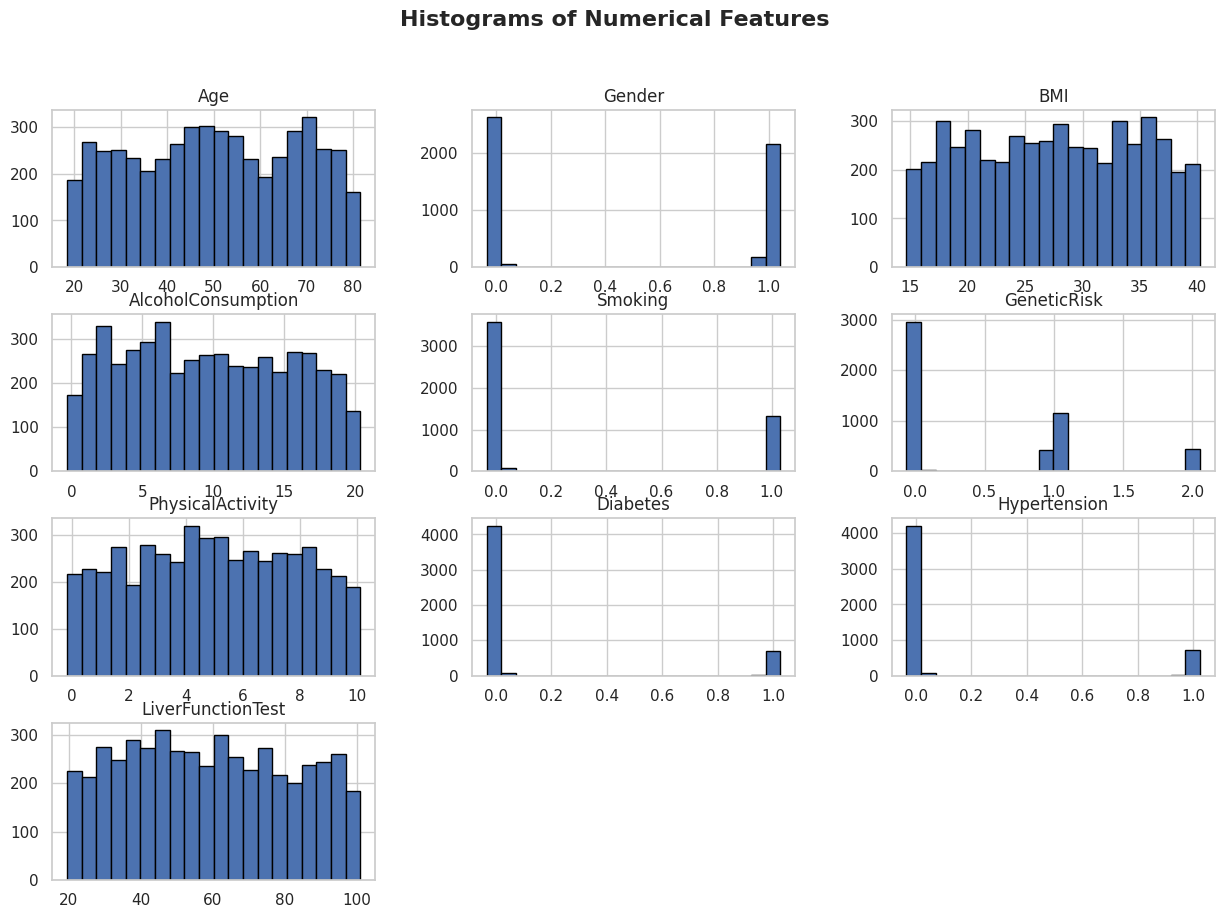

In [ ]:
# -------------------------
# 3) Numerical feature distributions
# -------------------------
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("Diagnosis")
df[num_cols].hist(bins=20, figsize=(15,10), color="#4c72b0", edgecolor="black")
plt.suptitle("Histograms of Numerical Features", fontsize=16, weight='bold')
plt.show()

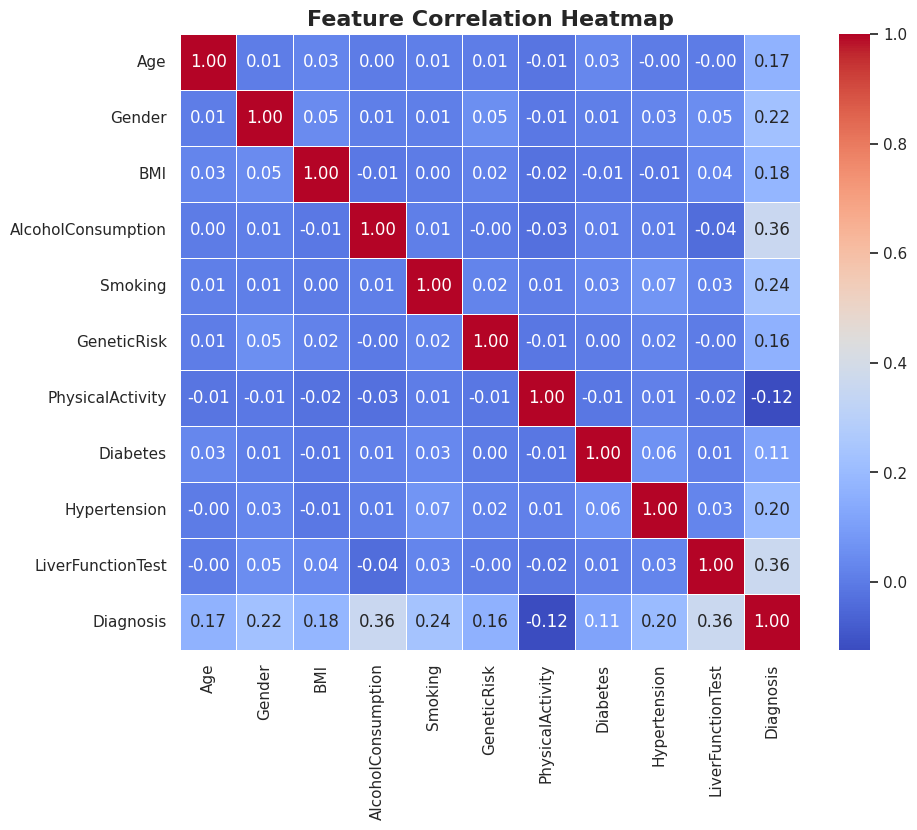

In [ ]:
# -------------------------
# 4) Correlation heatmap
# -------------------------
plt.figure(figsize=(10,8))
corr = df[num_cols.tolist() + ["Diagnosis"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16, weight='bold')
plt.show()

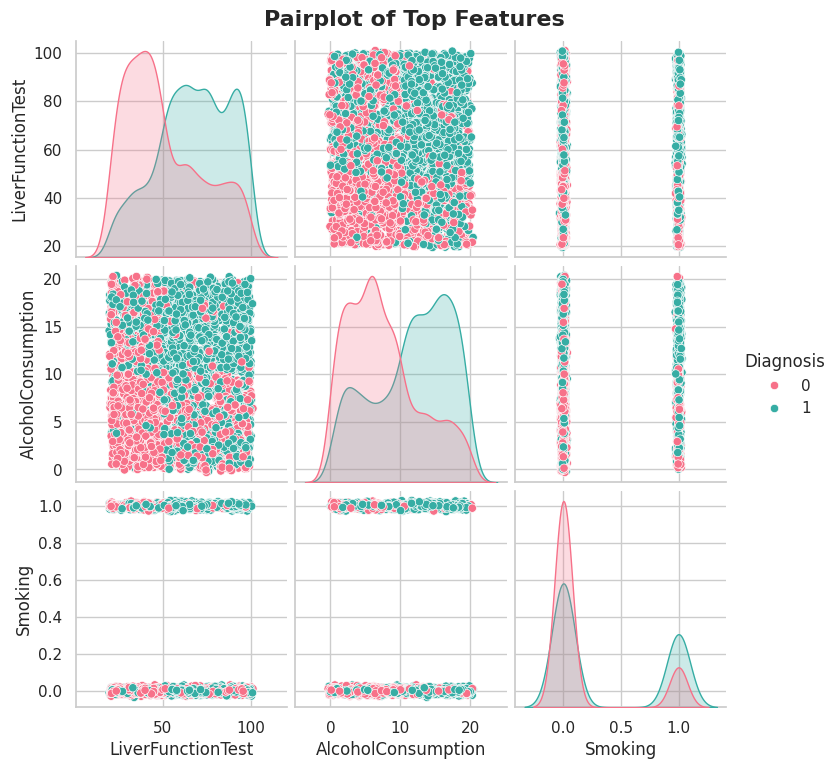

In [ ]:
# -------------------------
# 6) Pairplot for top correlated features
# -------------------------
top_corr = corr["Diagnosis"].abs().sort_values(ascending=False).head(4).index
sns.pairplot(df[top_corr], hue="Diagnosis", diag_kind="kde", palette="husl")
plt.suptitle("Pairplot of Top Features", y=1.02, fontsize=16, weight='bold')
plt.show()

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


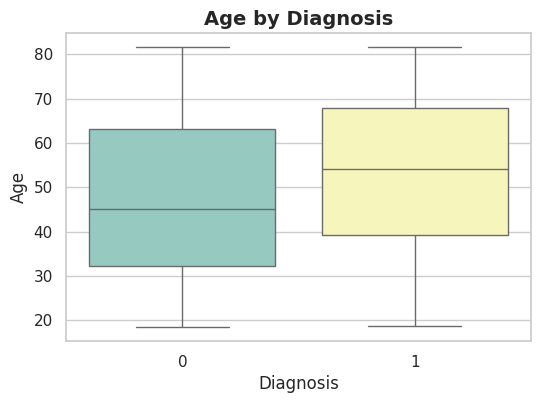

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


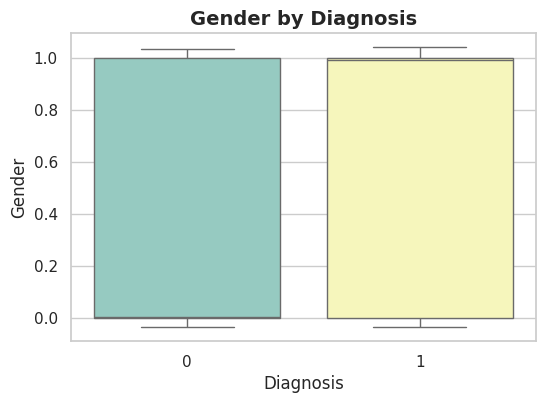

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


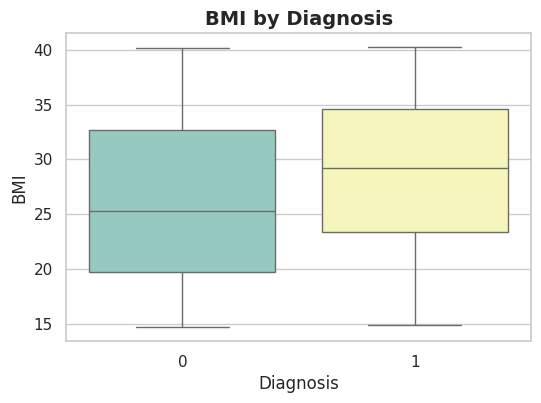

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


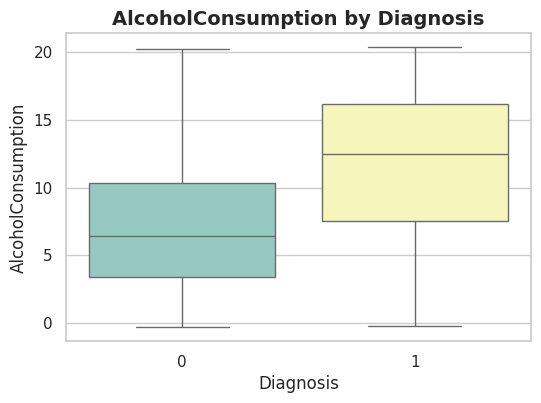

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


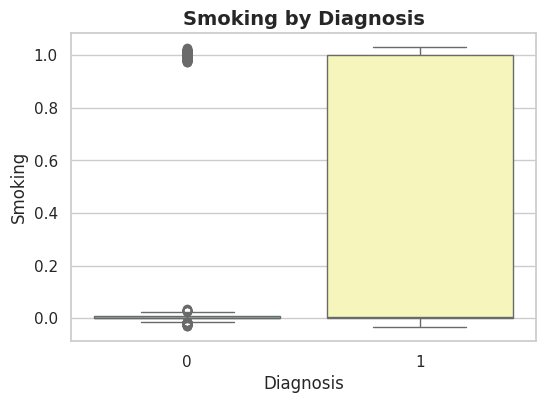

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


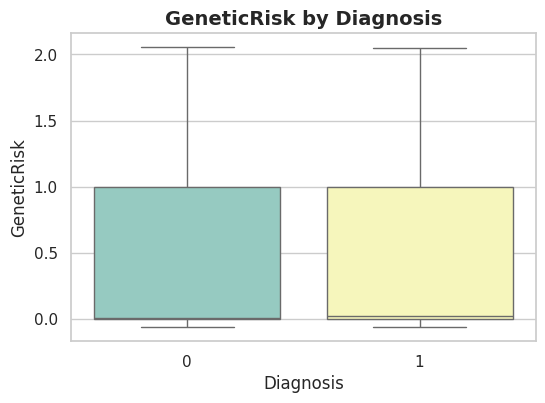

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


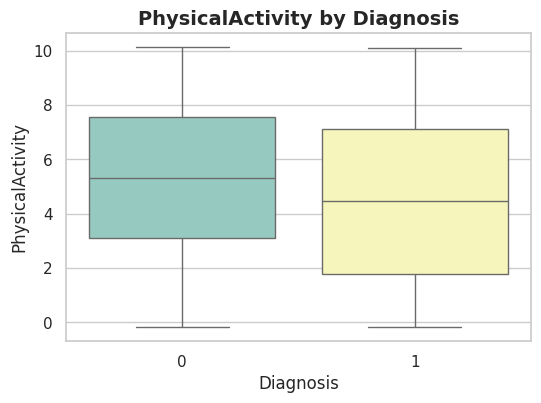

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


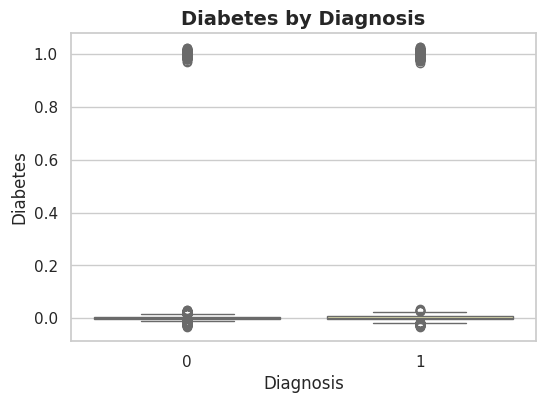

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


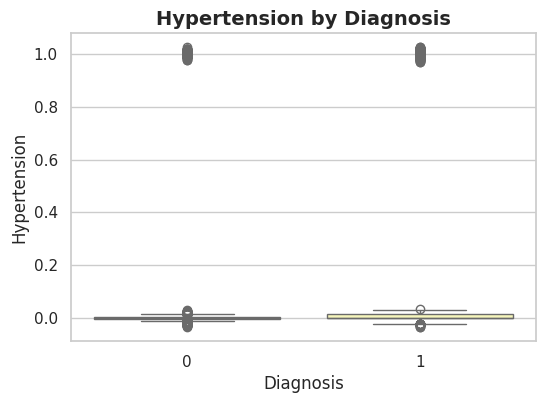

/tmp/ipython-input-4135506504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")


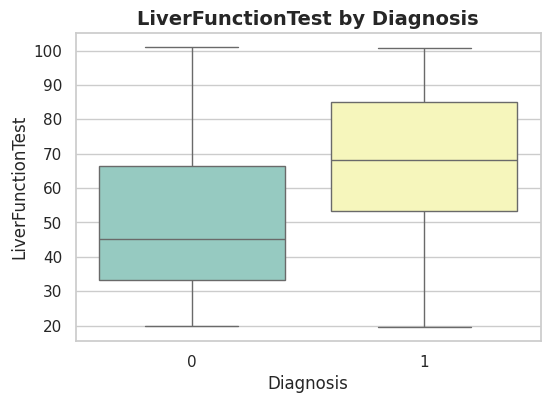

In [ ]:
# -------------------------
# 5) Boxplots to check outliers (per feature vs Diagnosis)
# -------------------------
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Diagnosis", y=col, palette="Set3")
    plt.title(f"{col} by Diagnosis", fontsize=14, weight='bold')
    plt.show()

In [ ]:
# -------- Reproducibility --------
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# -------- Load dataset --------
df = pd.read_csv(CSV_PATH)

In [ ]:
# Basic checks
assert "Diagnosis" in df.columns, "Target column 'Diagnosis' not found in the CSV."
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution (counts):\n", df["Diagnosis"].value_counts())
print("\nTarget distribution (%):\n", (df["Diagnosis"].value_counts(normalize=True)*100).round(2))


Shape: (5000, 11)

Dtypes:
 Age                   float64
Gender                float64
BMI                   float64
AlcoholConsumption    float64
Smoking               float64
GeneticRisk           float64
PhysicalActivity      float64
Diabetes              float64
Hypertension          float64
LiverFunctionTest     float64
Diagnosis               int64
dtype: object

Missing values per column:
 Age                   0
Gender                0
BMI                   0
AlcoholConsumption    0
Smoking               0
GeneticRisk           0
PhysicalActivity      0
Diabetes              0
Hypertension          0
LiverFunctionTest     0
Diagnosis             0
dtype: int64

Target distribution (counts):
 Diagnosis
1    2547
0    2453
Name: count, dtype: int64

Target distribution (%):
 Diagnosis
1    50.94
0    49.06
Name: proportion, dtype: float64


In [ ]:
# -------- Feature / Target --------
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"].astype(int)

# -------- Train / Test Split --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)
print(f"\nTrain shape: {X_train.shape} | Test shape: {X_test.shape}")


Train shape: (4000, 10) | Test shape: (1000, 10)


In [ ]:
# -------- Scaling for models that need it (LR, SVM, DNN) --------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\nPrepared:")
print("- X_train, X_test  (for tree models: RF, XGBoost)")
print("- X_train_scaled, X_test_scaled  (for LR, SVM, DNN)")



Prepared:
- X_train, X_test  (for tree models: RF, XGBoost)
- X_train_scaled, X_test_scaled  (for LR, SVM, DNN)


# ===== Stable Evaluation Kit =====


In [ ]:


def _get_probabilities(model, X):
    """
    Returns P(class=1) robustly:
    - If predict_proba exists: use it
    - Else if decision_function exists: min-max scale to [0,1]
    - Else fall back to predicted label as prob (0/1)
    """
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        # Handle binary and multi-output safely
        if p.ndim == 2 and p.shape[1] >= 2:
            return p[:, 1]
        return p.ravel()
    if hasattr(model, "decision_function"):
        z = model.decision_function(X)
        z = np.asarray(z).ravel()
        # Min-max to [0,1]
        z_min, z_max = z.min(), z.max()
        if z_max > z_min:
            return (z - z_min) / (z_max - z_min)
        # All same: map ≥0 to 1, else 0
        return (z >= 0).astype(float)
    # Last resort: use predicted class as prob
    return model.predict(X).astype(float)

def evaluate_model(model, name, X_test, y_test):
    """
    Evaluate an already-fitted model and return a standardized results dict.
    Also returns y_pred and y_prob for plotting.
    """
    y_pred = model.predict(X_test)
    y_prob = _get_probabilities(model, X_test)

    cm_counts = confusion_matrix(y_test, y_pred)
    cm_norm   = confusion_matrix(y_test, y_pred, normalize="true")
    tn, fp, fn, tp = cm_counts.ravel()

    results = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "CM_counts": cm_counts.tolist(),
        "CM_norm": cm_norm.tolist(),
        "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
    }

    # Auto-attach feature importance / coefficients if available
    if hasattr(model, "feature_importances_"):
        results["Feature_Importance"] = pd.Series(
            model.feature_importances_
        )
    if hasattr(model, "coef_"):
        # coef_ can be (1, n_features) for binary
        coef = np.ravel(model.coef_)
        results["Coefficients"] = pd.Series(coef)

    return results, y_pred, y_prob

def plot_conf_mats(results):
    """Plot confusion matrices (counts + normalized) from results dict."""
    cm_c = np.array(results["CM_counts"])
    cm_n = np.array(results["CM_norm"])
    name = results.get("Model", "Model")

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay(confusion_matrix=cm_c).plot(ax=ax[0], colorbar=False)
    ax[0].set_title(f"Confusion Matrix (Counts) — {name}")

    ConfusionMatrixDisplay(confusion_matrix=cm_n).plot(ax=ax[1], colorbar=False, values_format=".2f")
    ax[1].set_title(f"Confusion Matrix (Normalized) — {name}")
    plt.tight_layout(); plt.show()

def plot_curves(y_true, y_prob, name="Model"):
    """ROC + PR curves."""
    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title(f"ROC Curve — {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_prob)
    plt.title(f"Precision–Recall Curve — {name}")
    plt.show()

def plot_metrics_bar(results):
    """Bar chart from results dict (auto picks numeric metrics)."""
    name = results.get("Model", "Model")
    metric_keys = ["Accuracy","Precision","Recall","F1-score","ROC-AUC"]
    data = {k: results[k] for k in metric_keys if k in results}

    plt.figure(figsize=(8,5))
    bars = plt.bar(list(data.keys()), list(data.values()))
    plt.ylim(0, 1)
    plt.title(f"{name} Performance Metrics")
    plt.ylabel("Score")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, y + 0.01, f"{y:.2f}", ha="center")
    plt.show()

def plot_importance_or_coef(model, results, feature_names=None):
    """If model has feature_importances_ or coef_, plot them nicely."""
    name = results.get("Model", "Model")
    if "Feature_Importance" in results:
        s = results["Feature_Importance"]
        if feature_names is not None and len(feature_names) == len(s):
            s.index = feature_names
        s = s.sort_values(ascending=True)
        s.plot(kind="barh", figsize=(7,5))
        plt.title(f"Feature Importance — {name}")
        plt.tight_layout(); plt.show()
    elif "Coefficients" in results:
        s = results["Coefficients"]
        if feature_names is not None and len(feature_names) == len(s):
            s.index = feature_names
        s = s.sort_values(key=lambda x: np.abs(x), ascending=True)
        s.plot(kind="barh", figsize=(7,5))
        plt.title(f"Coefficients (scaled) — {name}")
        plt.tight_layout(); plt.show()


# 1) Logistic Regression (scaled)



{'Model': 'Logistic Regression', 'Accuracy': 0.86, 'Precision': 0.8742393509127789, 'Recall': 0.8467583497053045, 'F1-score': 0.8602794411177644, 'ROC-AUC': np.float64(0.9301293619132599), 'CM_counts': [[429, 62], [78, 431]], 'CM_norm': [[0.8737270875763747, 0.12627291242362526], [0.15324165029469547, 0.8467583497053045]], 'TN': 429, 'FP': 62, 'FN': 78, 'TP': 431, 'Coefficients': 0    0.591734
1    0.637239
2    0.598394
3    1.355760
4    0.787535
5    0.543076
6   -0.408164
7    0.330686
8    0.619540
9    1.280587
dtype: float64}


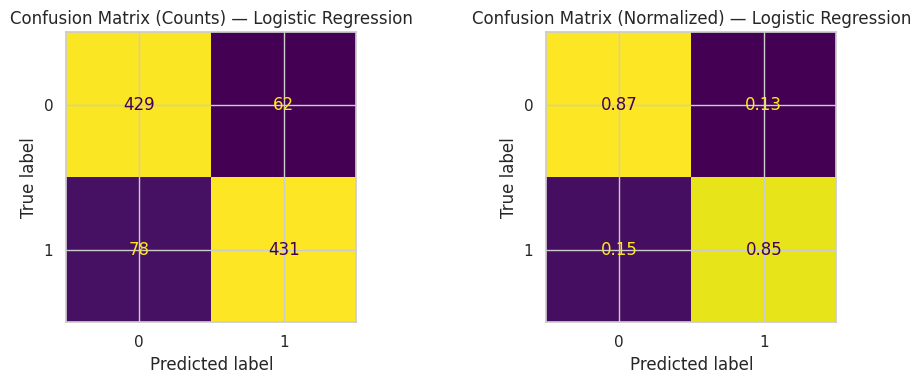

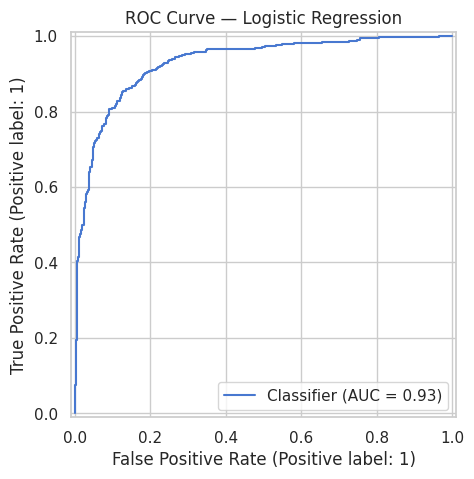

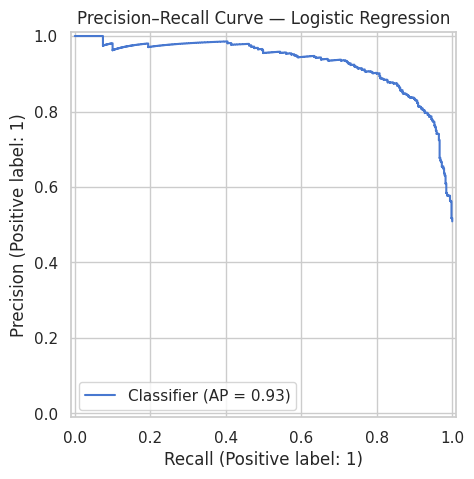

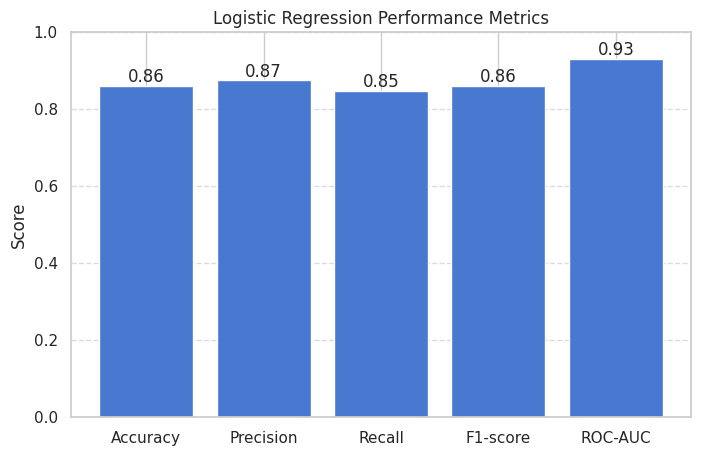

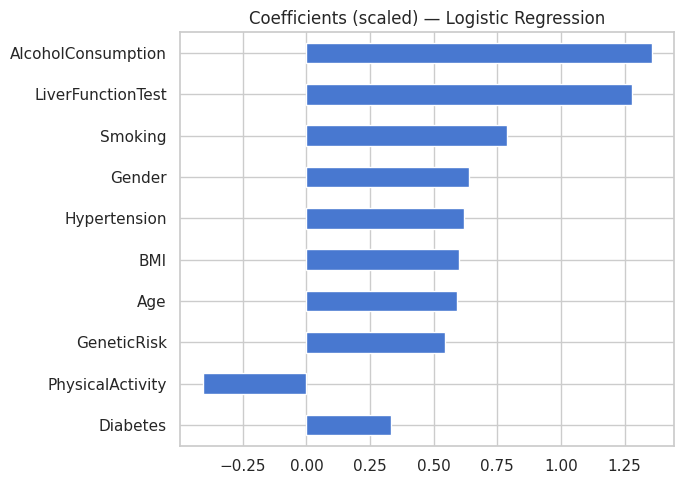

In [ ]:
#Define the model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

lr_results, lr_pred, lr_prob = evaluate_model(lr, "Logistic Regression", X_test_scaled, y_test)

print(lr_results)            # metrics + CM values (dynamic)
plot_conf_mats(lr_results)   # matrices
plot_curves(y_test, lr_prob, "Logistic Regression")
plot_metrics_bar(lr_results)
plot_importance_or_coef(lr, lr_results, feature_names=X_train.columns)


In [ ]:
# collect results for comparision in the last
try: all_results
except NameError: all_results = []
all_results = [r for r in all_results if r["Model"]!="Logistic Regression"]
all_results.append(lr_results)

# 2) Random Forest (unscaled)

{'Model': 'Random Forest', 'Accuracy': 0.967, 'Precision': 0.9630350194552529, 'Recall': 0.9724950884086444, 'F1-score': 0.967741935483871, 'ROC-AUC': np.float64(0.9942201273212521), 'CM_counts': [[472, 19], [14, 495]], 'CM_norm': [[0.9613034623217923, 0.038696537678207736], [0.0275049115913556, 0.9724950884086444]], 'TN': 472, 'FP': 19, 'FN': 14, 'TP': 495, 'Feature_Importance': 0    0.097173
1    0.065634
2    0.095272
3    0.224327
4    0.064373
5    0.071534
6    0.086454
7    0.029842
8    0.047607
9    0.217784
dtype: float64}


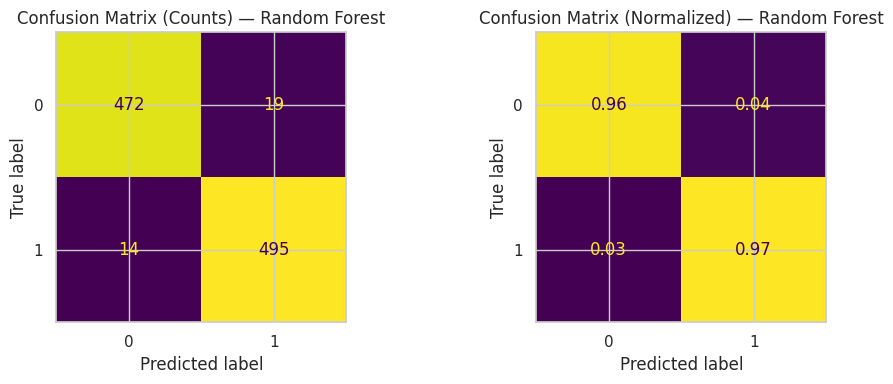

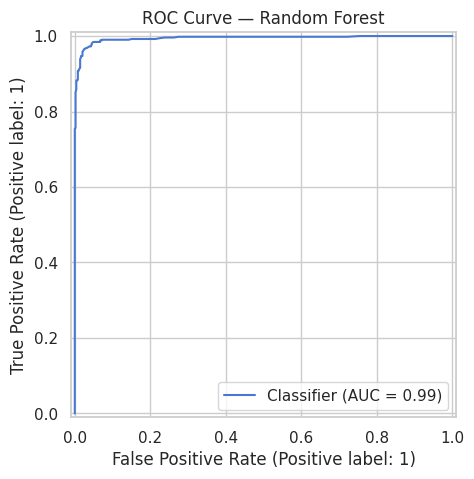

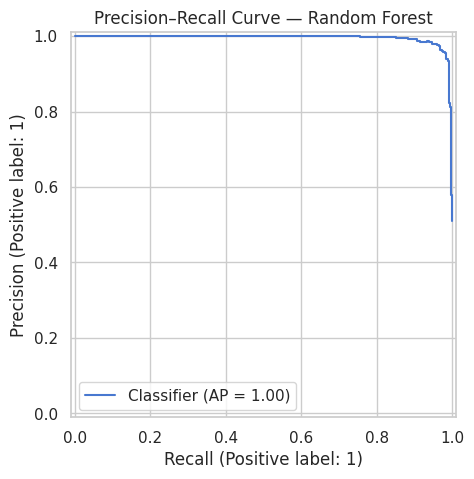

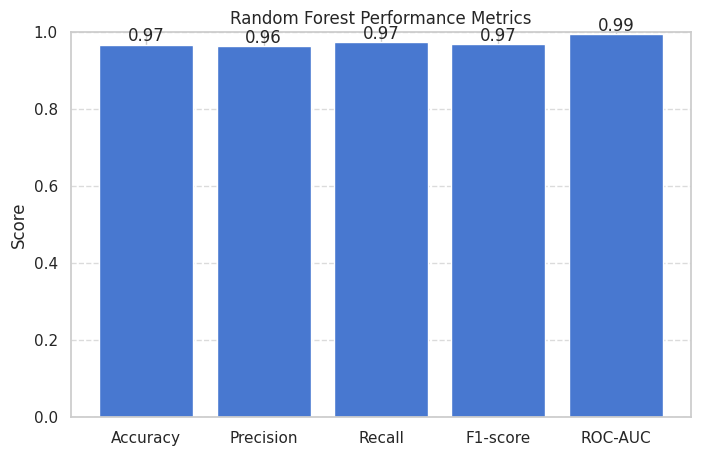

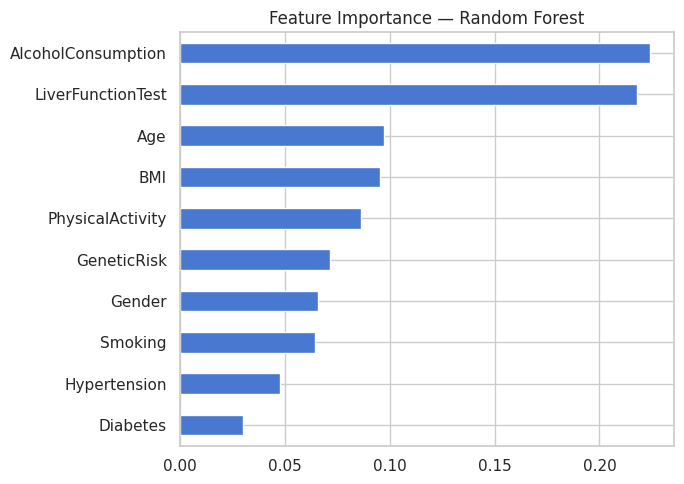

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_results, rf_pred, rf_prob = evaluate_model(rf, "Random Forest", X_test, y_test)

print(rf_results)
plot_conf_mats(rf_results)
plot_curves(y_test, rf_prob, "Random Forest")
plot_metrics_bar(rf_results)
plot_importance_or_coef(rf, rf_results, feature_names=X_train.columns)

all_results = [r for r in all_results if r["Model"]!="Random Forest"]
all_results.append(rf_results)


# 3) XGBoost (unscaled)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Model': 'XGBoost', 'Accuracy': 0.969, 'Precision': 0.9631782945736435, 'Recall': 0.9764243614931237, 'F1-score': 0.9697560975609756, 'ROC-AUC': np.float64(0.9940380683341402), 'CM_counts': [[472, 19], [12, 497]], 'CM_norm': [[0.9613034623217923, 0.038696537678207736], [0.023575638506876228, 0.9764243614931237]], 'TN': 472, 'FP': 19, 'FN': 12, 'TP': 497, 'Feature_Importance': 0    0.084606
1    0.115595
2    0.070511
3    0.140238
4    0.130184
5    0.107930
6    0.063988
7    0.064443
8    0.099717
9    0.122786
dtype: float32}


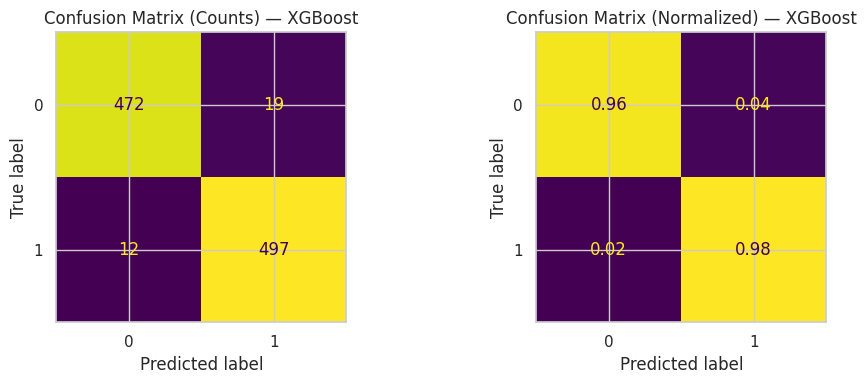

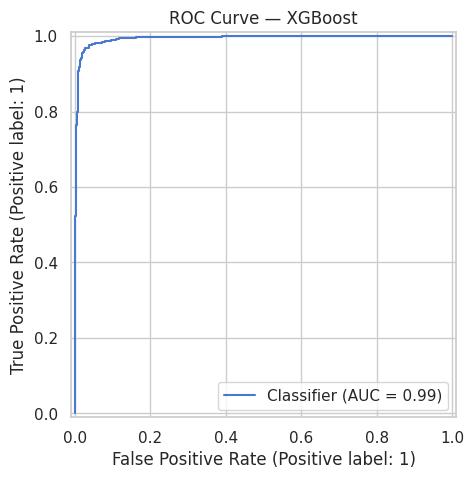

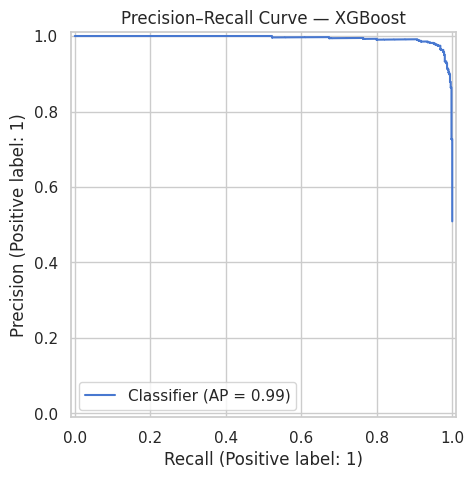

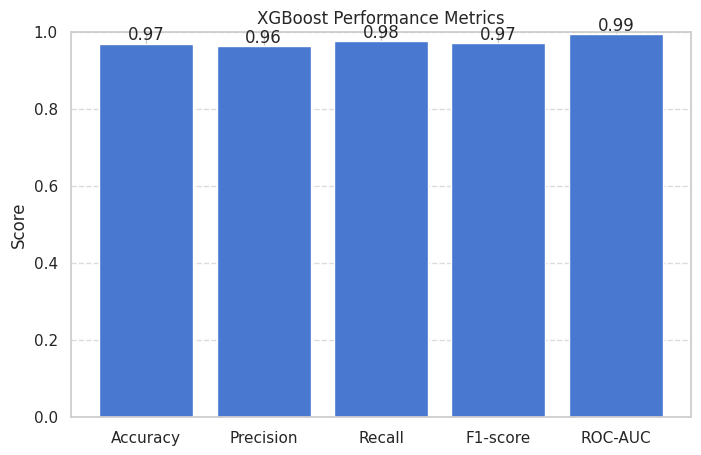

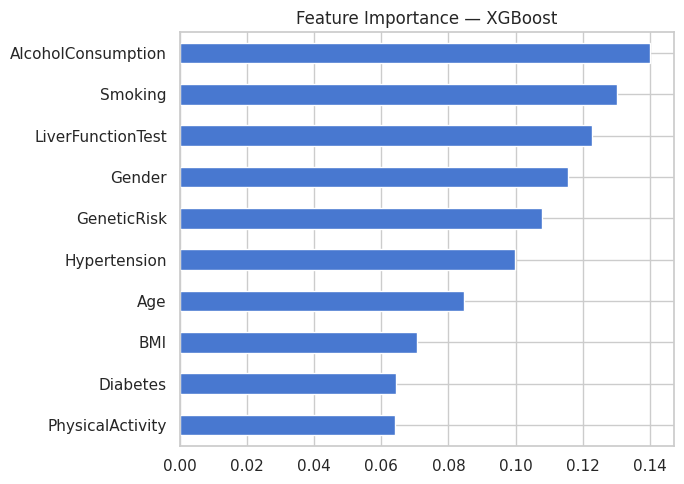

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5,
    random_state=42, use_label_encoder=False, eval_metric="logloss", n_jobs=-1
)
xgb.fit(X_train, y_train)

xgb_results, xgb_pred, xgb_prob = evaluate_model(xgb, "XGBoost", X_test, y_test)

print(xgb_results)
plot_conf_mats(xgb_results)
plot_curves(y_test, xgb_prob, "XGBoost")
plot_metrics_bar(xgb_results)
plot_importance_or_coef(xgb, xgb_results, feature_names=X_train.columns)

all_results = [r for r in all_results if r["Model"]!="XGBoost"]
all_results.append(xgb_results)


# 4) SVM (scaled)


{'Model': 'SVM (RBF)', 'Accuracy': 0.911, 'Precision': 0.9251012145748988, 'Recall': 0.8978388998035364, 'F1-score': 0.9112662013958126, 'ROC-AUC': np.float64(0.9633101124764424), 'CM_counts': [[454, 37], [52, 457]], 'CM_norm': [[0.924643584521385, 0.07535641547861507], [0.10216110019646366, 0.8978388998035364]], 'TN': 454, 'FP': 37, 'FN': 52, 'TP': 457}


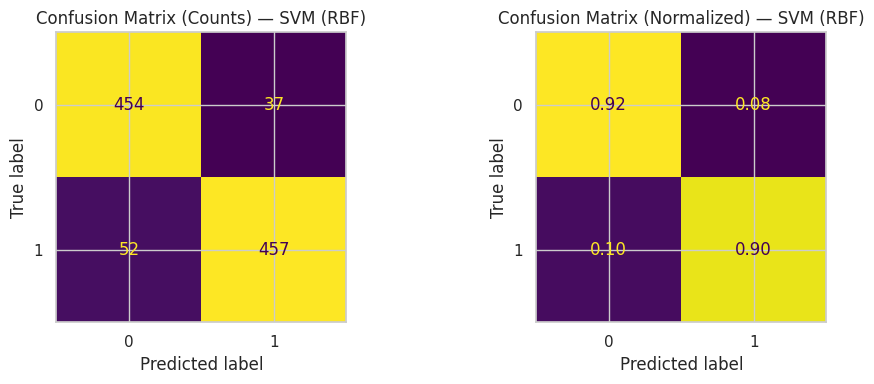

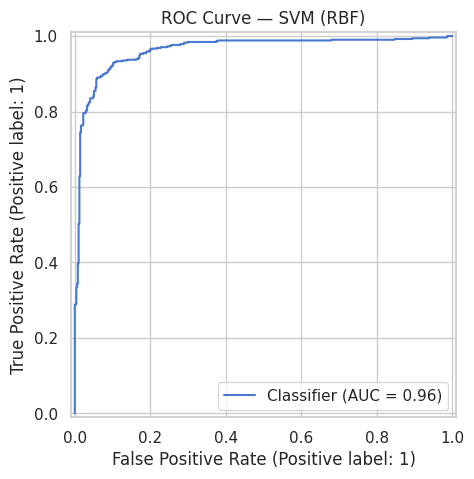

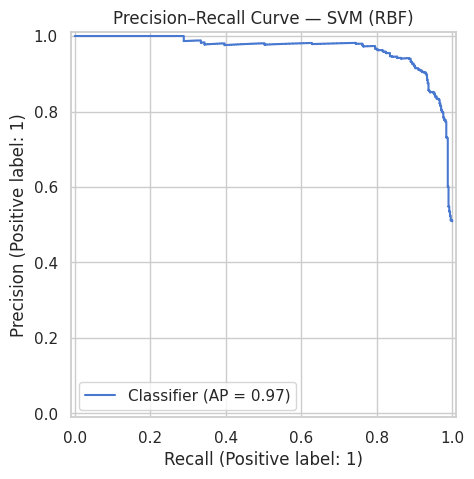

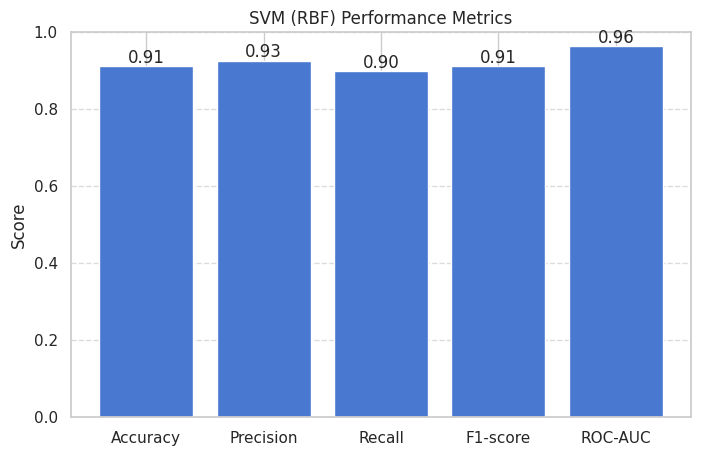

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

svm_results, svm_pred, svm_prob = evaluate_model(svm, "SVM (RBF)", X_test_scaled, y_test)

print(svm_results)
plot_conf_mats(svm_results)
plot_curves(y_test, svm_prob, "SVM (RBF)")
plot_metrics_bar(svm_results)

all_results = [r for r in all_results if r["Model"]!="SVM (RBF)"]
all_results.append(svm_results)


# 5)  STEP M1 — Final MLP pipeline (scale + MLP), evaluate & plot


=== MLP Pipeline Results ===
Accuracy  : 0.9690
Precision : 0.9723
Recall    : 0.9666
F1-score  : 0.9695
ROC-AUC   : 0.9894
TN        : 477
FP        : 14
FN        : 17
TP        : 492


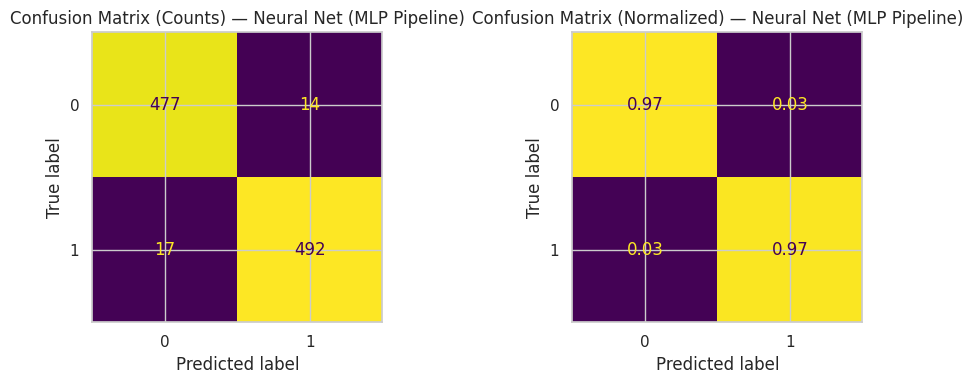

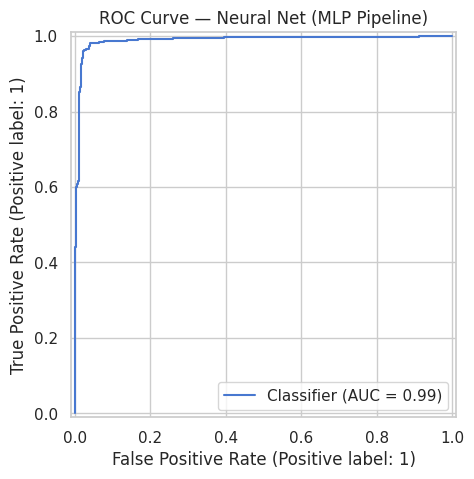

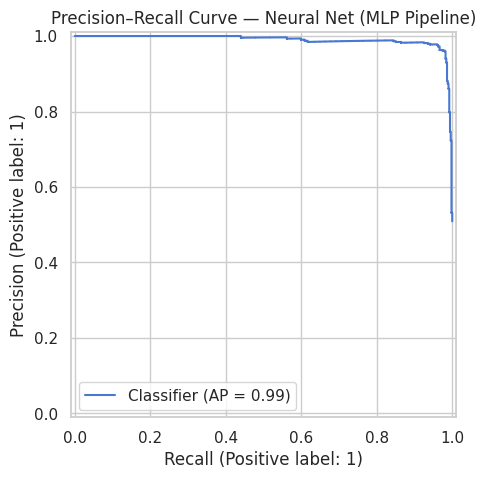

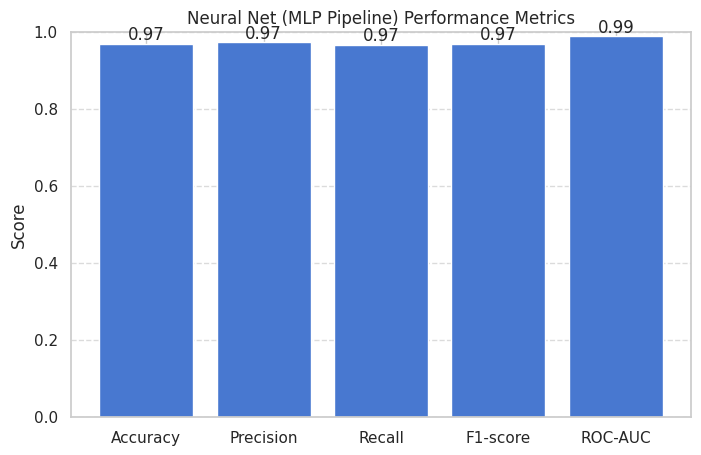


MLP structure: MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(128, 64),
              max_iter=500, n_iter_no_change=20, random_state=42)


In [ ]:

# 1) Build a robust pipeline (scaler inside to avoid leakage)
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        alpha=1e-3,                 # L2 regularization
        max_iter=500,
        early_stopping=True,        # use internal validation split
        n_iter_no_change=20,
        validation_fraction=0.1,
        random_state=42
    ))
])

# 2) Fit on training data
mlp_pipe.fit(X_train, y_train)

# 3) Evaluate using the Stable Eval Kit (works directly on X_test because scaler is inside)
mlp_results, mlp_pred, mlp_prob = evaluate_model(mlp_pipe, "Neural Net (MLP Pipeline)", X_test, y_test)

# 4) Show metrics + plots
print("\n=== MLP Pipeline Results ===")
for k in ["Accuracy","Precision","Recall","F1-score","ROC-AUC","TN","FP","FN","TP"]:
    print(f"{k:10s}: {mlp_results[k]:.4f}" if isinstance(mlp_results[k], float) else f"{k:10s}: {mlp_results[k]}")

plot_conf_mats(mlp_results)
plot_curves(y_test, mlp_prob, "Neural Net (MLP Pipeline)")
plot_metrics_bar(mlp_results)

# 5) (Optional) quick look at layer sizes used
print("\nMLP structure:", mlp_pipe.named_steps["mlp"])
# Note: feature importances aren't native for MLP. We'll add permutation importance next.


# Combine and compare multiple model results


=== Model Comparison Table ===
                       Model  Accuracy  Precision    Recall  F1-score  \
0        Logistic Regression     0.860   0.874239  0.846758  0.860279   
1              Random Forest     0.967   0.963035  0.972495  0.967742   
2                    XGBoost     0.969   0.963178  0.976424  0.969756   
3                  SVM (RBF)     0.911   0.925101  0.897839  0.911266   
4  Neural Net (MLP Pipeline)     0.969   0.972332  0.966601  0.969458   

    ROC-AUC  
0  0.930129  
1  0.994220  
2  0.994038  
3  0.963310  
4  0.989425  


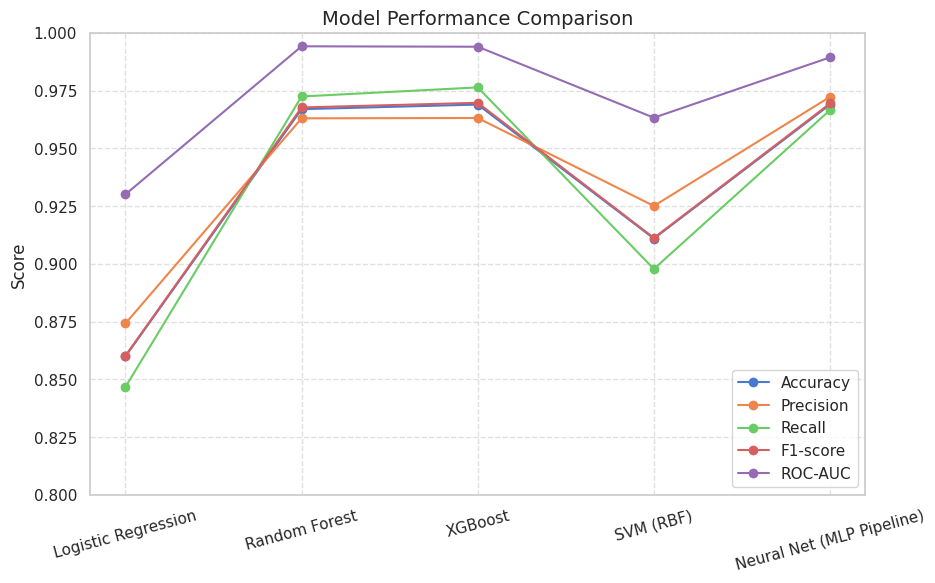

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Example: list of your 5 results dicts
all_results = [
    lr_results,
    rf_results,
    xgb_results,
    svm_results,
    mlp_results
]

# Convert to DataFrame
comparison_df = pd.DataFrame(all_results)

# Keep only numeric metrics for comparison
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
comparison_df_numeric = comparison_df[["Model"] + metrics]

# Display table
print("\n=== Model Comparison Table ===")
print(comparison_df_numeric)

# Plot comparison chart
plt.figure(figsize=(10,6))
for metric in metrics:
    plt.plot(comparison_df_numeric["Model"], comparison_df_numeric[metric],
             marker='o', label=metric)
plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0.80, 1.00)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(rotation=15)
plt.show()


# STEP H1 — Voting Classifier (MLP + Random Forest)



=== Voting (MLP + Random Forest) ===
Accuracy : 0.9790
Precision: 0.9803
Recall   : 0.9784
F1-score : 0.9794
ROC-AUC  : 0.9950


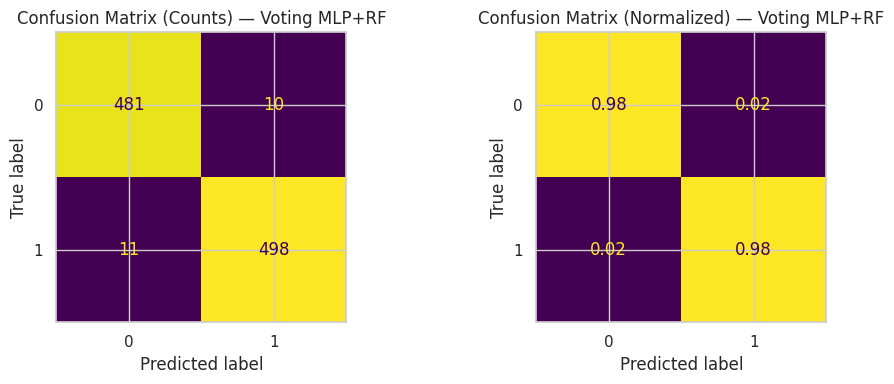

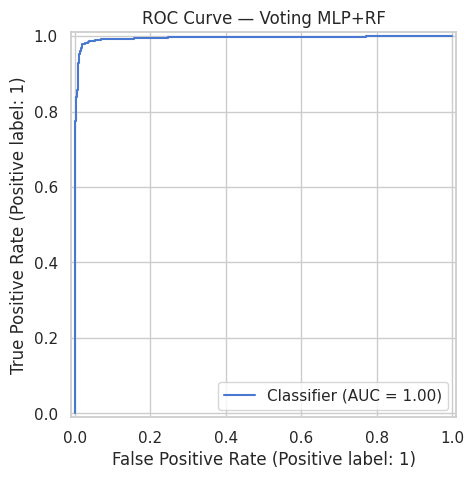

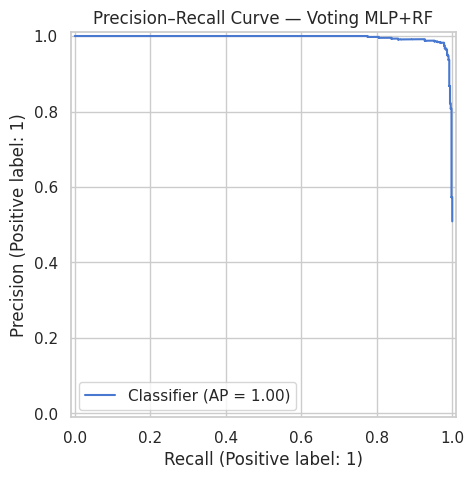

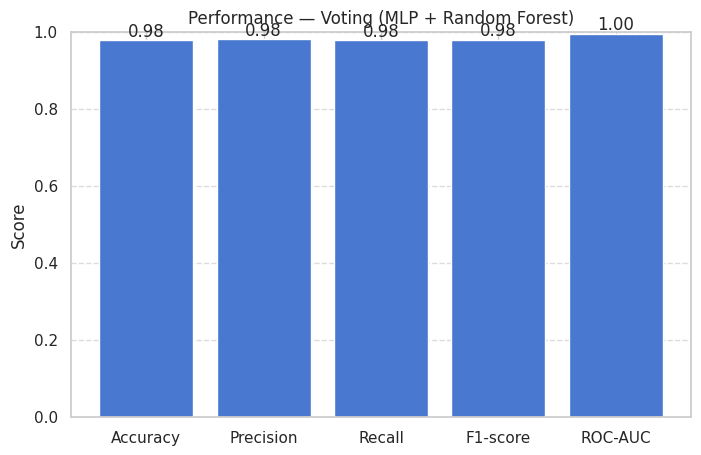

In [ ]:
# --- 1) Define base models ---
# MLP needs scaling → put scaler inside a Pipeline
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        alpha=1e-3,              # L2 regularization
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
        random_state=42
    ))
])

# RF doesn't need scaling
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# --- 2) Voting ensemble (soft voting = average probabilities) ---
vote_mlp_rf = VotingClassifier(
    estimators=[("mlp", mlp_pipe), ("rf", rf)],
    voting="soft",
    n_jobs=-1
)

# --- 3) Train on raw X_train/y_train (scaling is inside MLP pipeline only) ---
vote_mlp_rf.fit(X_train, y_train)

# --- 4) Predict on the test set ---
y_pred = vote_mlp_rf.predict(X_test)
y_prob = vote_mlp_rf.predict_proba(X_test)[:, 1]

# --- 5) Metrics ---
vote_mlp_rf_results = {
    "Model": "Voting (MLP + Random Forest)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
}
print("\n=== Voting (MLP + Random Forest) ===")
for k,v in vote_mlp_rf_results.items():
    if k != "Model":
        print(f"{k:9s}: {v:.4f}")

# --- 6) Confusion Matrices (counts + normalized) ---
cm_counts = confusion_matrix(y_test, y_pred)
cm_norm   = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm_counts).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix (Counts) — Voting MLP+RF")
ConfusionMatrixDisplay(cm_norm).plot(ax=ax[1], colorbar=False, values_format=".2f")
ax[1].set_title("Confusion Matrix (Normalized) — Voting MLP+RF")
plt.tight_layout(); plt.show()

# --- 7) ROC + PR curves ---
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Voting MLP+RF")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall Curve — Voting MLP+RF")
plt.show()

# --- 8) Bar chart of metrics ---
plt.figure(figsize=(8,5))
bars = plt.bar(["Accuracy","Precision","Recall","F1-score","ROC-AUC"],
               [vote_mlp_rf_results["Accuracy"], vote_mlp_rf_results["Precision"], vote_mlp_rf_results["Recall"], vote_mlp_rf_results["F1-score"], vote_mlp_rf_results["ROC-AUC"]])
plt.ylim(0,1)
plt.title("Performance — Voting (MLP + Random Forest)")
plt.ylabel("Score"); plt.grid(axis="y", linestyle="--", alpha=0.7)
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y+0.01, f"{y:.2f}", ha="center")
plt.show()

# ===============================
# STEP H2 — Voting Classifier (MLP + XGBoost)
# ===============================
1.    Uses MLP (with internal scaling) + XGBoost in a soft-voting ensemble.
2.    Assumes X_train, X_test, y_train, y_test already exist.


=== Voting (MLP + XGBoost) ===
Accuracy : 0.9750
Precision: 0.9764
Recall   : 0.9745
F1-score : 0.9754
ROC-AUC  : 0.9950


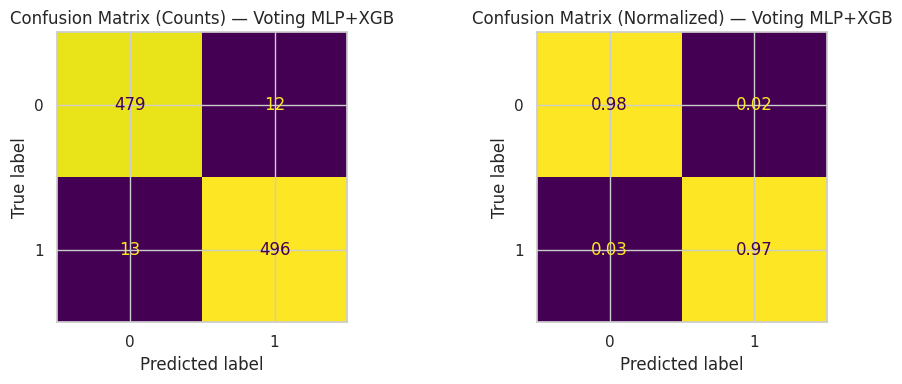

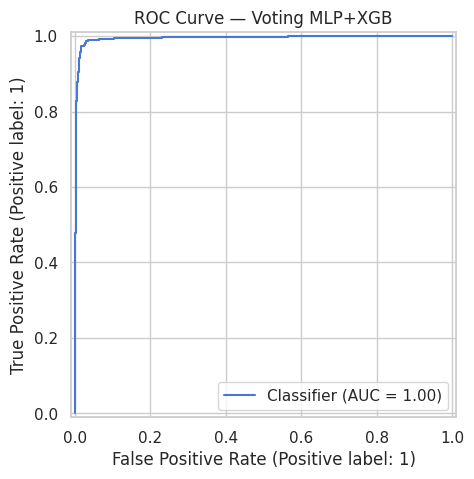

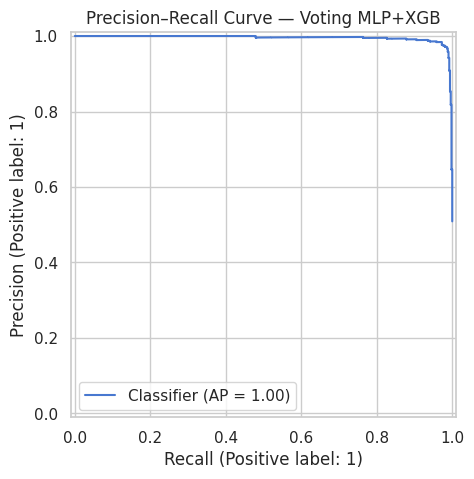

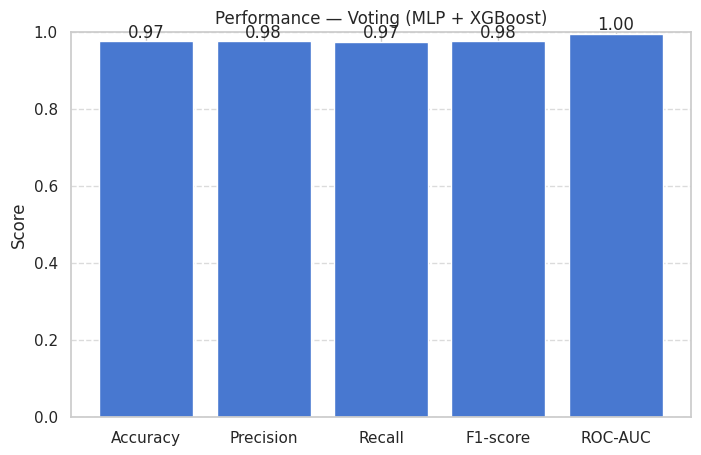

In [ ]:
# 1) Base models
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        alpha=1e-3,
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
        random_state=42
    ))
])

xgb = XGBClassifier(
    n_estimators=150,          # raise to 200-400 if you want (slower)
    learning_rate=0.1,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1
)

# 2) Voting ensemble (soft voting = average probabilities)
vote_mlp_xgb = VotingClassifier(
    estimators=[("mlp", mlp_pipe), ("xgb", xgb)],
    voting="soft",
    n_jobs=-1
)

# 3) Train
vote_mlp_xgb.fit(X_train, y_train)

# 4) Predict
y_pred = vote_mlp_xgb.predict(X_test)
y_prob = vote_mlp_xgb.predict_proba(X_test)[:, 1]

# 5) Metrics
vote_mlp_xgb_results = {
    "Model": "Voting (MLP + XGBoost)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
}
print("\n=== Voting (MLP + XGBoost) ===")
for k,v in vote_mlp_xgb_results.items():
    if k != "Model":
        print(f"{k:9s}: {v:.4f}")

# 6) Confusion Matrices
cm_counts = confusion_matrix(y_test, y_pred)
cm_norm   = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm_counts).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix (Counts) — Voting MLP+XGB")
ConfusionMatrixDisplay(cm_norm).plot(ax=ax[1], colorbar=False, values_format=".2f")
ax[1].set_title("Confusion Matrix (Normalized) — Voting MLP+XGB")
plt.tight_layout(); plt.show()

# 7) ROC + PR curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Voting MLP+XGB")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall Curve — Voting MLP+XGB")
plt.show()

# 8) Bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(["Accuracy","Precision","Recall","F1-score","ROC-AUC"],
               [vote_mlp_xgb_results["Accuracy"], vote_mlp_xgb_results["Precision"], vote_mlp_xgb_results["Recall"], vote_mlp_xgb_results["F1-score"], vote_mlp_xgb_results["ROC-AUC"]])
plt.ylim(0,1)
plt.title("Performance — Voting (MLP + XGBoost)")
plt.ylabel("Score"); plt.grid(axis="y", linestyle="--", alpha=0.7)
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y+0.01, f"{y:.2f}", ha="center")
plt.show()

# = FIX SAMPLE PREDICTIONS: REFIT IF NEEDED + SAFE PREDICT =


In [ ]:
# ---- 0) Your sample (make sure order matches X_train.columns) ----
sample_data = pd.DataFrame([[
    55,    # Age
    1,     # Gender
    27.5,  # BMI
    15.0,  # AlcoholConsumption
    0,     # Smoking
    1,     # GeneticRisk
    5.5,   # PhysicalActivity
    0,     # Diabetes
    1,     # Hypertension
    60.0   # LiverFunctionTest
]], columns=X_train.columns)


In [ ]:
# ---- 1) tiny helpers ----
def is_fitted(model) -> bool:
    try:
        check_is_fitted(model)
        return True
    except Exception:
        return False

def align_features_for(model, df: pd.DataFrame) -> pd.DataFrame:
    """If model remembers feature_names_in_, align to that order; else return df as-is."""
    if hasattr(model, "feature_names_in_"):
        cols = list(model.feature_names_in_)
        return df[cols]
    return df

def prob_of_one(model, X):
    """Robust probability for class 1."""
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p[:, 1] if p.ndim == 2 else p.ravel()
    if hasattr(model, "decision_function"):
        z = model.decision_function(X)
        z = np.asarray(z).ravel()
        z_min, z_max = z.min(), z.max()
        return (z - z_min) / (z_max - z_min) if z_max > z_min else (z >= 0).astype(float)
    # fallback
    return model.predict(X).astype(float)

In [ ]:
# ---- 2) (Re)define & fit models if missing / not fitted ----
# Random Forest
if 'rf_model' not in globals() or not is_fitted(globals()['rf_model']):
    print("↻ (Re)training Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

# XGBoost
if 'xgb_model' not in globals() or not is_fitted(globals()['xgb_model']):
    print("↻ (Re)training XGBoost...")
    xgb_model = XGBClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=5,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, use_label_encoder=False, eval_metric="logloss", n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)

↻ (Re)training Random Forest...
↻ (Re)training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# MLP inside a Pipeline (handles scaling automatically)
if 'mlp_pipe' not in globals() or not is_fitted(globals()['mlp_pipe']):
    print("↻ (Re)training MLP Pipeline...")
    mlp_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            solver="adam",
            learning_rate_init=0.001,
            alpha=1e-3,
            max_iter=500,
            early_stopping=True,
            n_iter_no_change=20,
            validation_fraction=0.1,
            random_state=42
        ))
    ])
    mlp_pipe.fit(X_train, y_train)

↻ (Re)training MLP Pipeline...


In [ ]:
# Voting (MLP + RF)
if 'vote_mlp_rf' not in globals() or not is_fitted(globals()['vote_mlp_rf']):
    from sklearn.ensemble import VotingClassifier
    print("↻ (Re)training Voting (MLP + RF)...")
    vote_mlp_rf = VotingClassifier(
        estimators=[("mlp", mlp_pipe), ("rf", rf_model)],
        voting="soft", n_jobs=-1
    )
    vote_mlp_rf.fit(X_train, y_train)

# Voting (MLP + XGB)
if 'vote_mlp_xgb' not in globals() or not is_fitted(globals()['vote_mlp_xgb']):
    from sklearn.ensemble import VotingClassifier
    print("↻ (Re)training Voting (MLP + XGB)...")
    vote_mlp_xgb = VotingClassifier(
        estimators=[("mlp", mlp_pipe), ("xgb", xgb_model)],
        voting="soft", n_jobs=-1
    )
    vote_mlp_xgb.fit(X_train, y_train)

↻ (Re)training Voting (MLP + RF)...
↻ (Re)training Voting (MLP + XGB)...


In [ ]:
# SVM may already be fitted; skip if you don’t use it now.

# ---- 3) Predict safely for each available model ----
models_to_test = {
    "Logistic Regression": globals().get("log_reg", None),   # if you trained it
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "SVM (RBF)": globals().get("svm_model", None),           # add if trained
    "MLP": mlp_pipe,
    "Voting (MLP + RF)": vote_mlp_rf,
    "Voting (MLP + XGB)": vote_mlp_xgb
}
models_to_test = {k:v for k,v in models_to_test.items() if v is not None}

rows = []
for name, model in models_to_test.items():
    try:
        X_in = align_features_for(model, sample_data)
        # Some models were fit on arrays → if feature-name warnings appear, use .values:
        try:
            pred = model.predict(X_in)[0]
            prob = prob_of_one(model, X_in)[0]
        except Exception:
            pred = model.predict(X_in.values)[0]
            prob = prob_of_one(model, X_in.values)[0]
    except Exception as e:
        pred, prob = None, None
        print(f"⚠️ {name}: {e}")

    rows.append({
        "Model": name,
        "Predicted Class": pred,
        "Probability of Disease": None if prob is None else float(np.round(prob, 4))
    })

sample_results_df = pd.DataFrame(rows).sort_values("Probability of Disease", ascending=False)
print("\n               === Sample Record Predictions ===")
display(sample_results_df)



               === Sample Record Predictions ===


,Model,Predicted Class,Probability of Disease
0,Random Forest,1,1.0000
3,Voting (MLP + RF),1,0.9998
2,MLP,1,0.9996
4,Voting (MLP + XGB),1,0.9980
1,XGBoost,1,0.9965


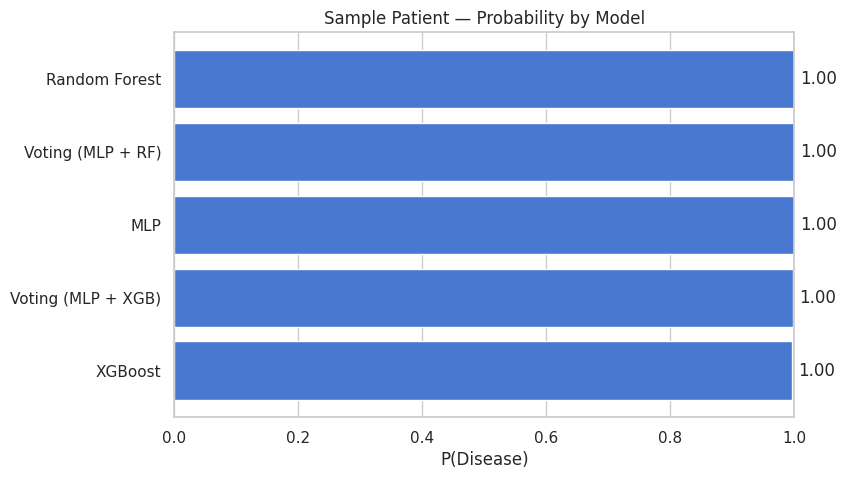

In [ ]:
# ---- 4) Optional: pretty probability comparison bar chart ----
valid = sample_results_df.dropna(subset=["Probability of Disease"])
plt.figure(figsize=(8,5))
plt.barh(valid["Model"], valid["Probability of Disease"])
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("P(Disease)")
plt.title("Sample Patient — Probability by Model")
for i,(m,p) in enumerate(zip(valid["Model"], valid["Probability of Disease"])):
    plt.text(p+0.01, i, f"{p:.2f}", va="center")
plt.show()

# 2 more hybrid models

RF & SVM + XGB + MLP


Weighted Voting (Calibrated) Results
Accuracy : 0.9670
Precision: 0.9612
Recall   : 0.9745
F1-score : 0.9678
ROC-AUC  : 0.9913


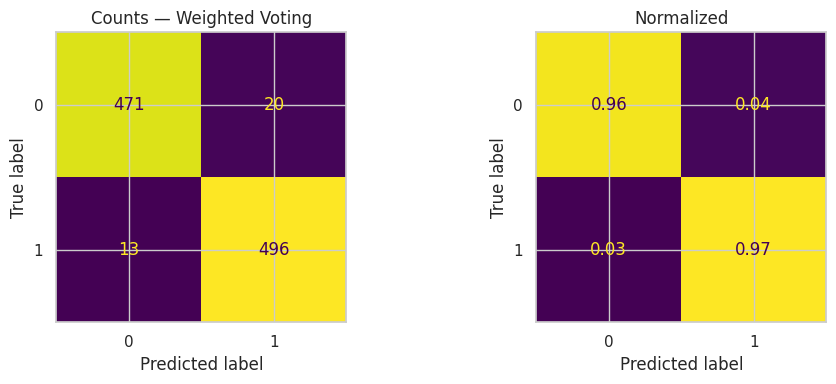

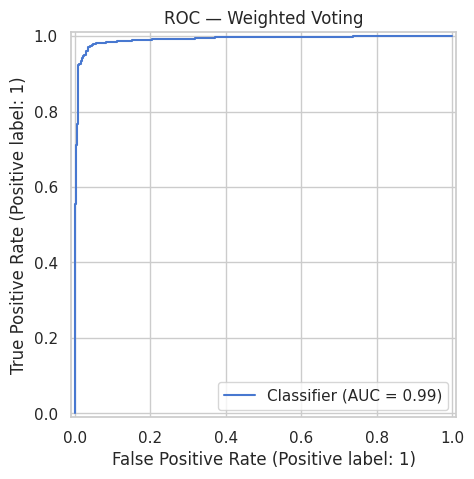

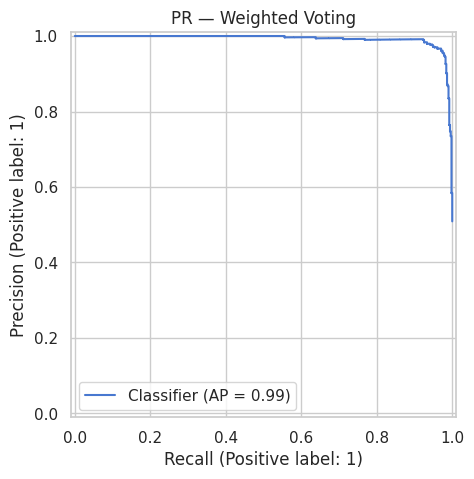

In [ ]:
# --- Weighted Soft Voting (Calibrated RF & SVM + XGB + MLP) ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Base models
rf_raw  = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
svm_raw = None  # optional: add your SVM here if trained

# Calibrate (Platt scaling = 'sigmoid', 5-fold CV)
rf_cal = CalibratedClassifierCV(rf_raw, cv=5, method='sigmoid')

mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500,
                          early_stopping=True, random_state=42))
])

xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                    subsample=0.9, colsample_bytree=0.9,
                    random_state=42, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)

# Voting with weights (tune these if you want)
estimators = [("mlp", mlp_pipe), ("xgb", xgb), ("rf", rf_cal)]
weights = [1.2, 1.3, 1.0]   # start: give a bit more weight to MLP & XGB

vote_w = VotingClassifier(estimators=estimators, voting="soft", weights=weights, n_jobs=-1)
vote_w.fit(X_train, y_train)

y_pred = vote_w.predict(X_test)
y_prob = vote_w.predict_proba(X_test)[:,1]

weighted_vote_results = {
    "Model": "Weighted Voting (Calibrated)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
}

print("\nWeighted Voting (Calibrated) Results")
for k,v in weighted_vote_results.items():
    if k != "Model":
        print(f"{k:9s}: {v:.4f}")

# quick plots
cm = confusion_matrix(y_test, y_pred)
cmn = confusion_matrix(y_test, y_pred, normalize='true')
fig,ax=plt.subplots(1,2,figsize=(10,4))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], colorbar=False); ax[0].set_title("Counts — Weighted Voting")
ConfusionMatrixDisplay(cmn).plot(ax=ax[1], colorbar=False, values_format=".2f"); ax[1].set_title("Normalized")
plt.tight_layout(); plt.show()
RocCurveDisplay.from_predictions(y_test, y_prob); plt.title("ROC — Weighted Voting"); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob); plt.title("PR — Weighted Voting"); plt.show()

MLP + XGBoost + RF → meta‑learner Logistic Regression


Stacking (MLP + XGB + RF → LR) Results
Accuracy : 0.9680
Precision: 0.9631
Recall   : 0.9745
F1-score : 0.9688
ROC-AUC  : 0.9928


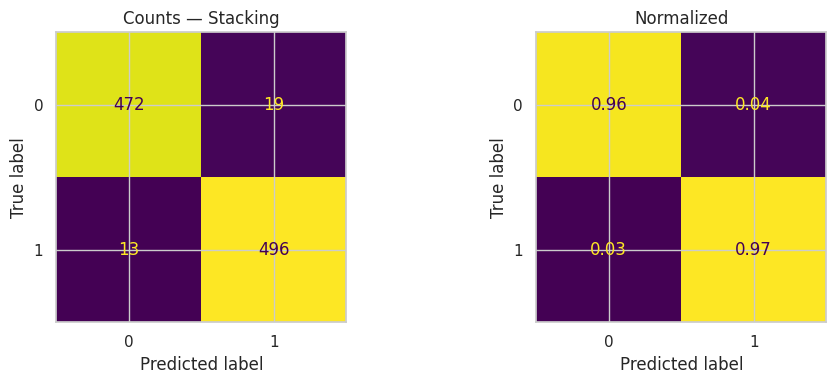

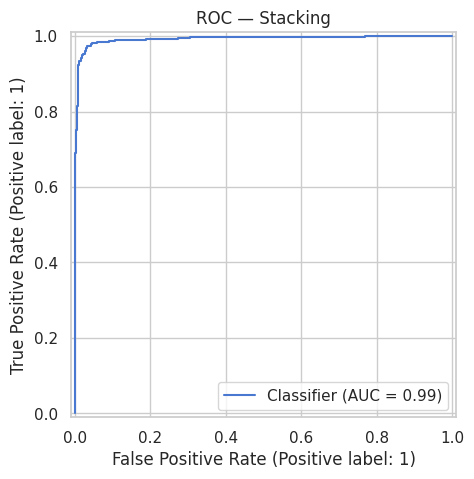

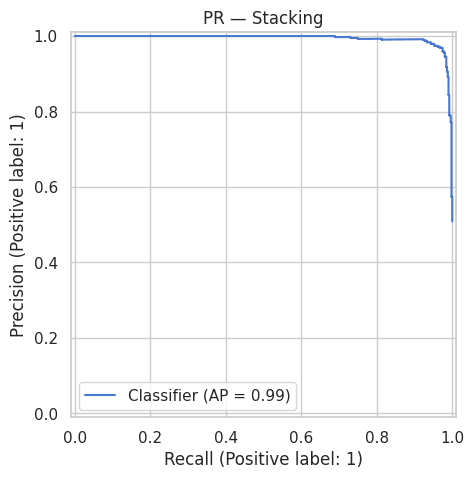

In [ ]:
# --- Stacking: MLP + XGB + RF  -> meta: LogisticRegression ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500,
                          early_stopping=True, random_state=42))
])

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                    subsample=0.9, colsample_bytree=0.9,
                    random_state=42, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)

stack = StackingClassifier(
    estimators=[("mlp", mlp_pipe), ("xgb", xgb), ("rf", rf)],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba",   # use class-1 probabilities as meta features
    passthrough=False,              # set True to also pass original features
    cv=5,                           # out-of-fold predictions for meta training
    n_jobs=-1
)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
y_prob = stack.predict_proba(X_test)[:,1]

stacking_results = {
    "Model": "Stacking (MLP + XGB + RF → LR)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
}

print("\nStacking (MLP + XGB + RF → LR) Results")
for k,v in stacking_results.items():
    if k != "Model":
        print(f"{k:9s}: {v:.4f}")

cm = confusion_matrix(y_test, y_pred)
cmn = confusion_matrix(y_test, y_pred, normalize='true')
fig,ax=plt.subplots(1,2,figsize=(10,4))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], colorbar=False); ax[0].set_title("Counts — Stacking")
ConfusionMatrixDisplay(cmn).plot(ax=ax[1], colorbar=False, values_format=".2f"); ax[1].set_title("Normalized")
plt.tight_layout(); plt.show()
RocCurveDisplay.from_predictions(y_test, y_prob); plt.title("ROC — Stacking"); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob); plt.title("PR — Stacking"); plt.show()

details for you only

---

## 1) Weighted Soft Voting (with Calibration)

**What it is:**
Combine multiple models by averaging their **probabilities**—but not equally. You give stronger models higher **weights**. Before averaging, you can **calibrate** models whose probabilities are over/under‑confident (e.g., Random Forest often overconfident).

**Why it can fix low accuracy:**

* If base models’ probabilities are mis‑scaled, the average can be biased. **Calibration** (Platt “sigmoid” or isotonic) makes the probabilities more truthful, so the weighted average is more meaningful.
* **Weights** let you favor the models that perform best on validation (e.g., by ROC‑AUC or F1), reducing the impact of weaker models.

**How it works (quick math):**
For a sample $x$, each model $m_i$ outputs $p_i = P(y=1|x)$. The ensemble probability is

$$
p_{\text{vote}} = \frac{\sum_i w_i \, \hat{p}_i}{\sum_i w_i}
$$

where $\hat{p}_i$ are **calibrated** probabilities, and $w_i$ are your weights. Final class = $1$ if $p_{\text{vote}} \ge \tau$ (default $\tau = 0.5$, but you can tune it).

**When to use:**

* You already have 2–4 strong models but accuracy/F1 is stuck.
* Probabilities look poorly calibrated (PR curve/precision at common thresholds looks off).
* You want a **simple, fast** ensemble without meta‑learning.

**Practical tuning:**

* Start with weights proportional to each model’s **ROC‑AUC** on validation: `w_i = AUC_i`.
* Try `CalibratedClassifierCV(..., method='sigmoid')` (fast, stable). If you have lots of data, `method='isotonic'` can be more flexible.
* Tune the **decision threshold** $\tau$ for your target (maximize F1 or reach desired recall).

**Pitfalls to avoid:**

* Don’t calibrate on the **same data** you later report on. Use CV inside `CalibratedClassifierCV` (it handles this).
* Too many weak models can dilute strong ones—use **weights** to control influence.

---

## 2) Stacking (Meta‑Learner)

**What it is:**
Train several base models; then train a **meta‑model** (e.g., Logistic Regression) on the **out‑of‑fold predictions** of those base models. The meta‑model learns **how to combine** them.

**Why it can fix low accuracy:**

* If models make **different mistakes**, stacking learns patterns like “trust XGBoost in region A, trust MLP in region B,” which plain averaging can’t do.
* Meta‑learner can also correct residual biases after seeing base models’ probability vectors.

**How it works (quick flow):**

1. Split the training set into K folds.
2. For each base model, get **out‑of‑fold** $p_i$ predictions for every training row (no leakage).
3. Concatenate these $p_i$s into a feature vector $[p_1, p_2, \dots]$; fit a **meta‑learner** on it.
4. At test time: get each base model’s probabilities on the test set → feed to meta‑learner → final prediction.

**When to use:**

* Your models are complementary (e.g., MLP + XGBoost + RF).
* Voting/Blending helped a bit, but you want **one level smarter** combination.
* You can afford a bit more training time (stacking is heavier than voting).

**Practical tuning:**

* `final_estimator=LogisticRegression(max_iter=1000)` is a great default.
* `stack_method='predict_proba'` so the meta‑learner sees calibrated‑ish probabilities.
* `cv=5` usually enough; increase if you have time.
* Try `passthrough=True` to also give original features to the meta‑learner (works well when base models underfit some areas).

**Pitfalls to avoid:**

* **Data leakage**: never train the meta‑learner on in‑fold predictions from base models; use **out‑of‑fold** (the sklearn `StackingClassifier` handles this for you).
* Overfitting if you use too many similar base learners; keep 2–4 strong, diverse models.



=== All Models Performance Comparison ===


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,CM_counts,CM_norm,TN,FP,FN,TP,Coefficients,Feature_Importance
0,Logistic Regression,0.860,0.874239,0.846758,0.860279,0.930129,"[[429, 62], [78, 431]]","[[0.8737270875763747, 0.12627291242362526], [0...",429.0,62.0,78.0,431.0,Age 0.591734 Gender ...,NaN
1,Random Forest,0.967,0.963035,0.972495,0.967742,0.994220,"[[472, 19], [14, 495]]","[[0.9613034623217923, 0.038696537678207736], [...",472.0,19.0,14.0,495.0,NaN,Age 0.097173 Gender ...
2,XGBoost,0.969,0.963178,0.976424,0.969756,0.994038,"[[472, 19], [12, 497]]","[[0.9613034623217923, 0.038696537678207736], [...",472.0,19.0,12.0,497.0,NaN,Age 0.084606 Gender ...
3,SVM (RBF),0.911,0.925101,0.897839,0.911266,0.963310,"[[454, 37], [52, 457]]","[[0.924643584521385, 0.07535641547861507], [0....",454.0,37.0,52.0,457.0,NaN,NaN
4,Neural Net (MLP Pipeline),0.969,0.972332,0.966601,0.969458,0.989425,"[[477, 14], [17, 492]]","[[0.9714867617107943, 0.028513238289205704], [...",477.0,14.0,17.0,492.0,NaN,NaN
5,Voting (MLP + Random Forest),0.979,0.980315,0.978389,0.979351,0.995022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Voting (MLP + XGBoost),0.975,0.976378,0.974460,0.975418,0.995006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Weighted Voting (Calibrated),0.967,0.961240,0.974460,0.967805,0.991297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Stacking (MLP + XGB + RF → LR),0.968,0.963107,0.974460,0.968750,0.992766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


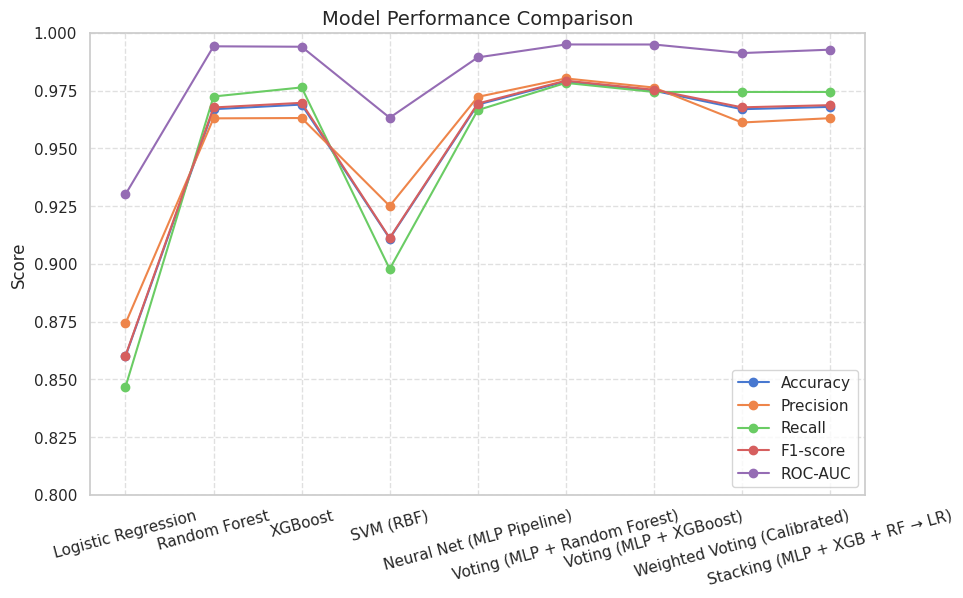

/tmp/ipython-input-3229052228.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(comparison_df["Model"], rotation=90)
/tmp/ipython-input-3229052228.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(comparison_df["Model"], rotation=90)
/tmp/ipython-input-3229052228.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(comparison_df["Model"], rotation=90)
/tmp/ipython-input-3229052228.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(comparison_df["Model"], rotation=90)
/tmp/ipython-input-3229052228.py:49: UserWarning: set_ticklabels() should only be used w

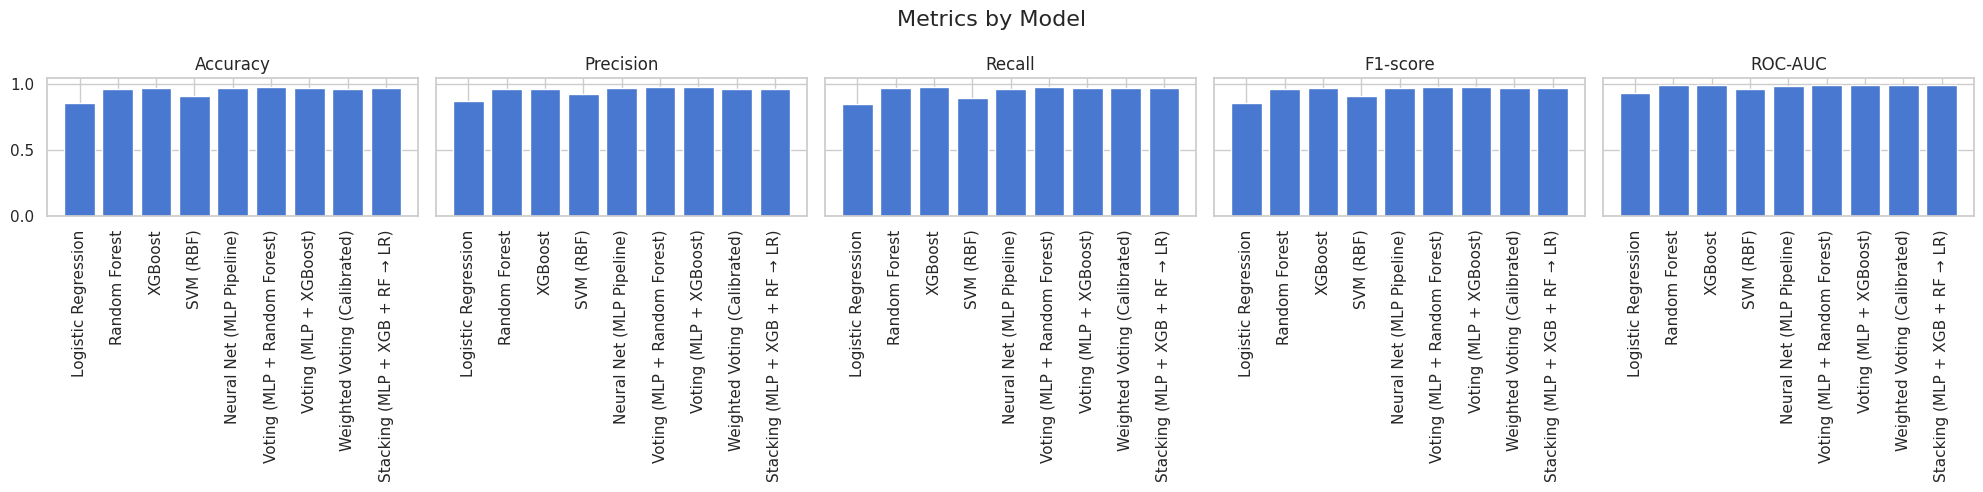

In [ ]:
# ============================================
# Combine and Compare All Models
# ============================================
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Collect results ---
# Each entry: {"Model": "...", "Accuracy": ..., "Precision": ..., "Recall": ..., "F1-score": ..., "ROC-AUC": ...}
# Replace these values with your actual results from earlier
all_results = [
    lr_results,             # Logistic Regression
    rf_results,             # Random Forest
    xgb_results,            # XGBoost
    svm_results,            # SVM
    mlp_results,            # MLP
    vote_mlp_rf_results,    # Voting (MLP + RF)
    vote_mlp_xgb_results,   # Voting (MLP + XGB)
    weighted_vote_results,  # Weighted Voting (Calibrated)
    stacking_results        # Stacking (MLP+XGB+RF → LR)
]

# Convert to DataFrame
comparison_df = pd.DataFrame(all_results)

# --- 2) Display table ---
print("\n=== All Models Performance Comparison ===")
display(comparison_df)

# --- 3) Plot multi-metric comparison ---
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]

plt.figure(figsize=(10,6))
for metric in metrics:
    plt.plot(comparison_df["Model"], comparison_df[metric],
             marker='o', label=metric)
plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0.80, 1.00)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(rotation=15)
plt.show()

# --- 4) Optional: Bar chart for each metric ---
fig, axes = plt.subplots(1, len(metrics), figsize=(20,5), sharey=True)
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df["Model"], comparison_df[metric])
    axes[i].set_title(metric)
    axes[i].set_xticklabels(comparison_df["Model"], rotation=90)
plt.suptitle("Metrics by Model", fontsize=16)
plt.tight_layout()
plt.show()

# Keras MLP for TFlite

In [ ]:
# === CONFIG ===
CSV_PATH = "/content/extended_liver_dataset.csv"  # change if needed
SEED = 42
TEST_SIZE = 0.2
EPOCHS = 30
BATCH_SIZE = 64

import numpy as np, pandas as pd, tensorflow as tf, os, json, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Load
df = pd.read_csv(CSV_PATH)
assert "Diagnosis" in df.columns, "Missing target 'Diagnosis'"
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"].astype(int).values

feature_names = X.columns.tolist()  # keep for deployment
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype("float32"), y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)
X_train.shape, X_test.shape


((4000, 10), (1000, 10))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Normalization layer learns mean/std from training features and becomes part of the graph
norm = Normalization()
norm.adapt(X_train)  # <- IMPORTANT: scaling baked into the exported model

model = Sequential([
    norm,
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

ckpt_path = "/content/mlp_liver_best.keras"
callbacks = [
    EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True)
]

# Add AUC metric for the callbacks
model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy",
              metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy"])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=callbacks, verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (4000, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (88.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21 (88.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7216 - auc: 0.8166 - loss: 0.5721 - val_accuracy: 0.8610 - val_auc: 0.9315 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8413 - auc: 0.9141 - loss: 0.3766 - val_accuracy: 0.8710 - val_auc: 0.9384 - val_loss: 0.3218 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564 - auc: 0.9227 - loss: 0.3588 - val_accuracy: 0.8790 - val_auc: 0.9421 - val_loss: 0.3108 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8610 - auc: 0.9289 - loss: 0.3427 - val_accuracy: 0.8790 - val_auc: 0.9453 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8620 - auc: 0.9318 - loss: 0.3376 - val_accuracy: 0.8820 - val_auc: 0.9486 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8630 - auc: 0.9359 - loss

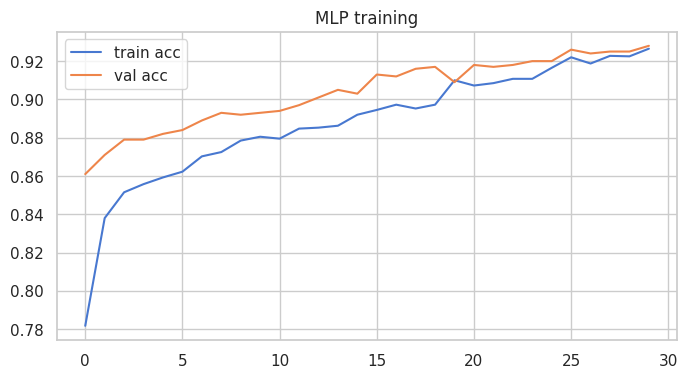

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("MLP training"); plt.show()

In [ ]:
# Predictions
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

results_mlp = {
    "Model":"Keras MLP",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
}
results_mlp


{'Model': 'Keras MLP',
 'Accuracy': 0.928,
 'Precision': 0.9309664694280079,
 'Recall': 0.9273084479371316,
 'F1-score': 0.9291338582677166,
 'ROC-AUC': np.float64(0.9747318131074467)}

In [ ]:
# SavedModel folder + Keras file
export_dir = "/content/mlp_liver_savedmodel"
model.export(export_dir)        # SavedModel
model.save("/content/mlp_liver.h5", include_optimizer=False)  # H5 (optional)

# Save feature order for the app
with open("/content/feature_names.json","w") as f:
    json.dump(feature_names, f, indent=2)
print("Saved:", export_dir)

Saved artifact at '/content/mlp_liver_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137926872748240: TensorSpec(shape=(1, 10), dtype=tf.float32, name=None)
  137926872747664: TensorSpec(shape=(1, 10), dtype=tf.float32, name=None)
  137926872757072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137926872759568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137926872757264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137926872760144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137926872154576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137926872155344: TensorSpec(shape=(), dtype=tf.resource, name=None)


Saved: /content/mlp_liver_savedmodel


In [ ]:
def convert_tflite(saved_model_dir, optimizations=None, rep_data=None, int8_full=False):
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    if optimizations:
        converter.optimizations = optimizations
    if rep_data is not None:
        def rep_dataset():
            for i in range(0, min(500, rep_data.shape[0]), 32):
                yield [rep_data[i:i+32]]
        converter.representative_dataset = rep_dataset
    if int8_full:
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    return tflite_model

# FP32
tflite_fp32 = convert_tflite(export_dir)
open("/content/mlp_liver_fp32.tflite","wb").write(tflite_fp32)

# (b) Dynamic range quantization (smaller, fast; weights int8, activations float)
tflite_dynamic = convert_tflite(export_dir, optimizations=[tf.lite.Optimize.DEFAULT])
open("/content/mlp_liver_dynamic.tflite","wb").write(tflite_dynamic)

# (c) Full int8 quantization (weights + activations), needs representative data
tflite_int8 = convert_tflite(
    export_dir,
    optimizations=[tf.lite.Optimize.DEFAULT],
    rep_data=X_train.astype("float32"),
    int8_full=True
)
open("/content/mlp_liver_int8.tflite","wb").write(tflite_int8)

print("TFLite files written:",
      "mlp_liver_fp32.tflite, mlp_liver_dynamic.tflite, mlp_liver_int8.tflite")


TFLite files written: mlp_liver_fp32.tflite, mlp_liver_dynamic.tflite, mlp_liver_int8.tflite


In [ ]:
def tflite_predict(tflite_path, inputs: np.ndarray):
    # inputs must be raw features in the same order (the model has Normalization inside)
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    x = inputs.astype(input_details["dtype"])
    # If int8 model, apply quantization params
    if input_details["dtype"] == np.int8:
        scale, zero = input_details["quantization"]
        x = (x / scale + zero).astype(np.int8)

    interpreter.set_tensor(input_details["index"], x)
    interpreter.invoke()
    out = interpreter.get_tensor(output_details["index"])

    # De-quantize output if int8
    if output_details["dtype"] == np.int8:
        scale, zero = output_details["quantization"]
        out = (out.astype(np.float32) - zero) * scale
    return out.ravel()

# Example single patient (order must match feature_names)
sample = np.array([[55,1,27.5,15.0,0,1,5.5,0,1,60.0]], dtype=np.float32)

for path in ["/content/mlp_liver_fp32.tflite",
             "/content/mlp_liver_dynamic.tflite",
             "/content/mlp_liver_int8.tflite"]:
    prob = tflite_predict(path, sample)[0]
    pred = int(prob >= 0.5)
    print(os.path.basename(path), "→ Prob:", round(float(prob),4), " Pred:", pred)


mlp_liver_fp32.tflite → Prob: 0.9623  Pred: 1
mlp_liver_dynamic.tflite → Prob: 0.9618  Pred: 1
mlp_liver_int8.tflite → Prob: 0.9766  Pred: 1


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# 1: accuracy comparison graph (All Model )



=== Model Accuracy Comparison ===


,Model,Accuracy
0,Logistic Regression,0.860
1,Random Forest,0.967
2,XGBoost,0.969
3,SVM (RBF),0.911
4,Neural Net (MLP Pipeline),0.969
5,Voting (MLP + Random Forest),0.979
6,Voting (MLP + XGBoost),0.975
7,Weighted Voting (Calibrated),0.967
8,Stacking (MLP + XGB + RF → LR),0.968


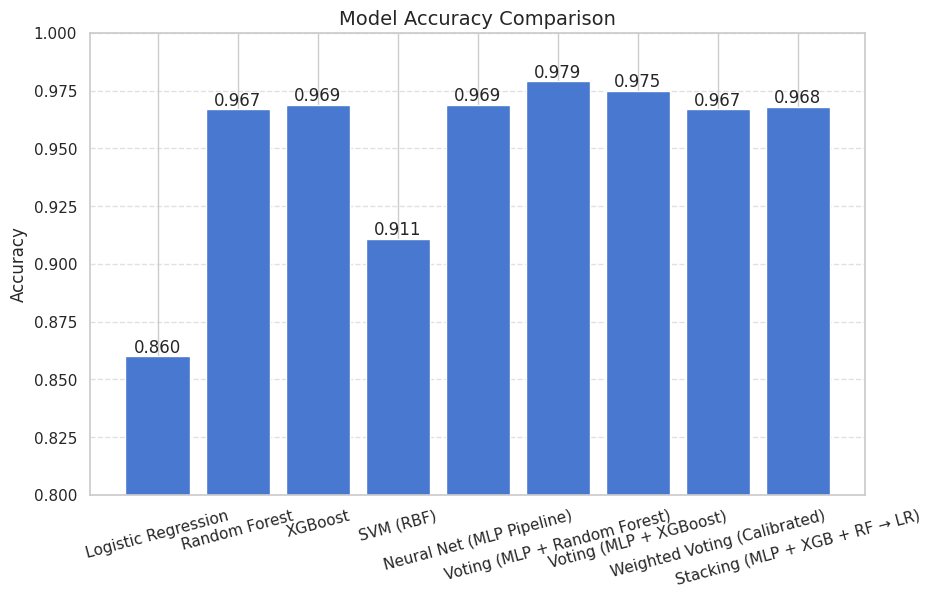

In [ ]:
# ============================================
# Compare Model Accuracies
# ============================================
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Collect results ---
# Ensure all_results list contains your model results dictionaries
all_results = [
    lr_results,             # Logistic Regression
    rf_results,             # Random Forest
    xgb_results,            # XGBoost
    svm_results,            # SVM
    mlp_results,            # MLP
    vote_mlp_rf_results,    # Voting (MLP + RF)
    vote_mlp_xgb_results,   # Voting (MLP + XGB)
    weighted_vote_results,  # Weighted Voting (Calibrated)
    stacking_results        # Stacking (MLP+XGB+RF → LR)
]

# Convert to DataFrame and select only Model and Accuracy
comparison_df = pd.DataFrame(all_results)
accuracy_df = comparison_df[["Model", "Accuracy"]]

# --- 2) Display table ---
print("\n=== Model Accuracy Comparison ===")
display(accuracy_df)

# --- 3) Plot bar chart for Accuracy ---
plt.figure(figsize=(10,6))
bars = plt.bar(accuracy_df["Model"], accuracy_df["Accuracy"])
plt.ylim(0.80, 1.00)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=15)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

plt.show()


=== Model Accuracy Comparison ===


,Model,Accuracy
0,Logistic Regression,0.860
1,Random Forest,0.967
2,XGBoost,0.969
3,SVM (RBF),0.911
4,Neural Net (MLP Pipeline),0.969
5,Voting (MLP + Random Forest),0.979
6,Voting (MLP + XGBoost),0.975
7,Weighted Voting (Calibrated),0.967
8,Stacking (MLP + XGB + RF → LR),0.968


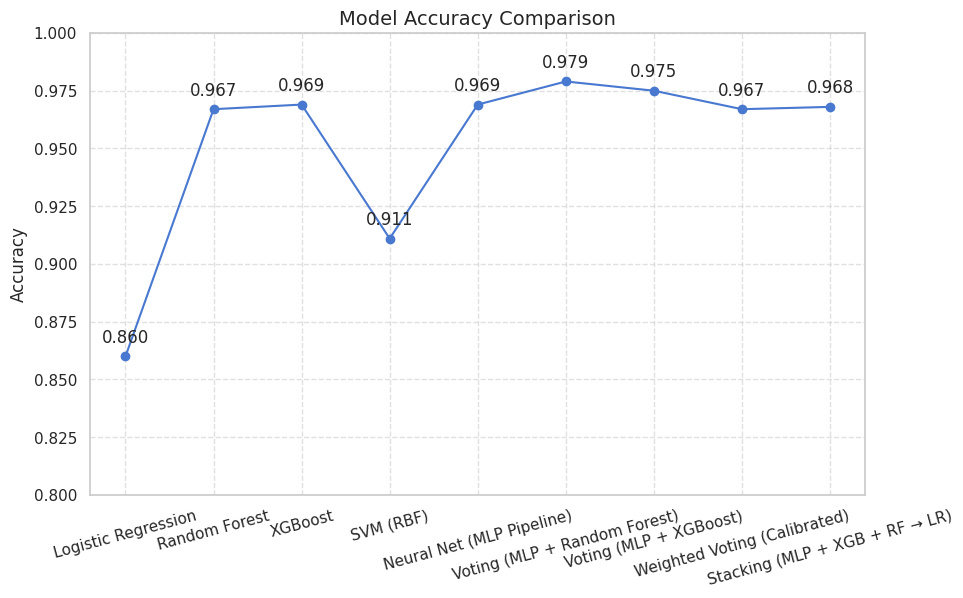

In [ ]:
# ============================================
# Compare Model Accuracies - Line Chart
# ============================================
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Collect results ---
# Ensure all_results list contains your model results dictionaries
all_results = [
    lr_results,             # Logistic Regression
    rf_results,             # Random Forest
    xgb_results,            # XGBoost
    svm_results,            # SVM
    mlp_results,            # MLP
    vote_mlp_rf_results,    # Voting (MLP + RF)
    vote_mlp_xgb_results,   # Voting (MLP + XGB)
    weighted_vote_results,  # Weighted Voting (Calibrated)
    stacking_results        # Stacking (MLP+XGB+RF → LR)
]

# Convert to DataFrame and select only Model and Accuracy
comparison_df = pd.DataFrame(all_results)
accuracy_df = comparison_df[["Model", "Accuracy"]]

# --- 2) Display table ---
print("\n=== Model Accuracy Comparison ===")
display(accuracy_df)

# --- 3) Plot line chart for Accuracy ---
plt.figure(figsize=(10,6))
plt.plot(accuracy_df["Model"], accuracy_df["Accuracy"], marker='o')
plt.ylim(0.80, 1.00)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=15)

# Add values next to points
for i, txt in enumerate(accuracy_df["Accuracy"]):
    plt.annotate(f'{txt:.3f}', (accuracy_df["Model"][i], accuracy_df["Accuracy"][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# 2 :  highest Model  Mlp + RF  
Seperate( ROC  ),
(confusion Matrix)
 (Accuracy ,precision,recall ,f1 Score, ROC-AUC)


=== Voting (MLP + Random Forest) Metrics ===
Accuracy : 0.9790
Precision: 0.9803
Recall   : 0.9784
F1-score : 0.9794
ROC-AUC  : 0.9950


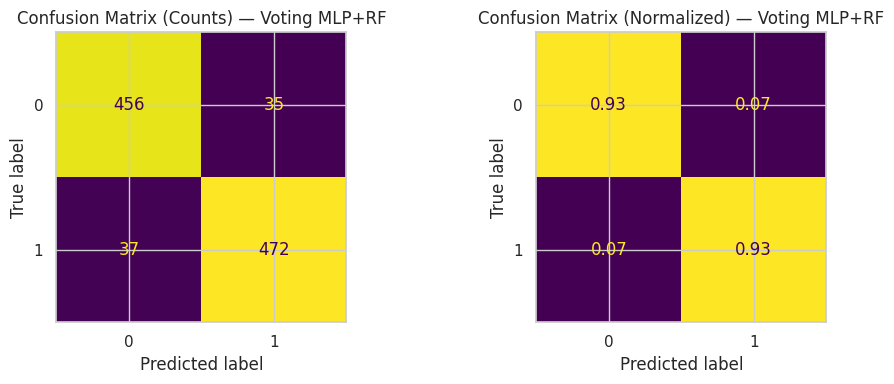

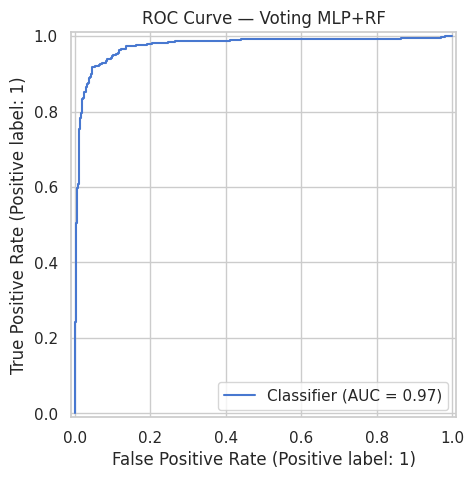

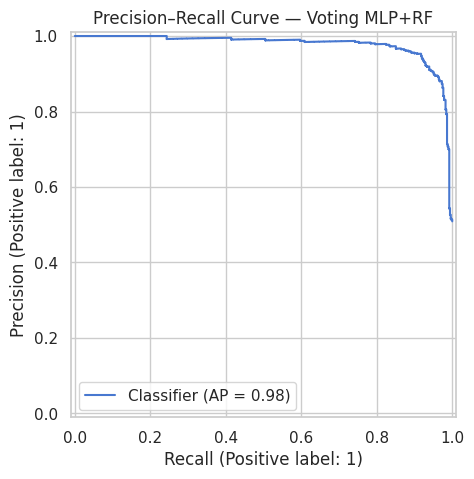

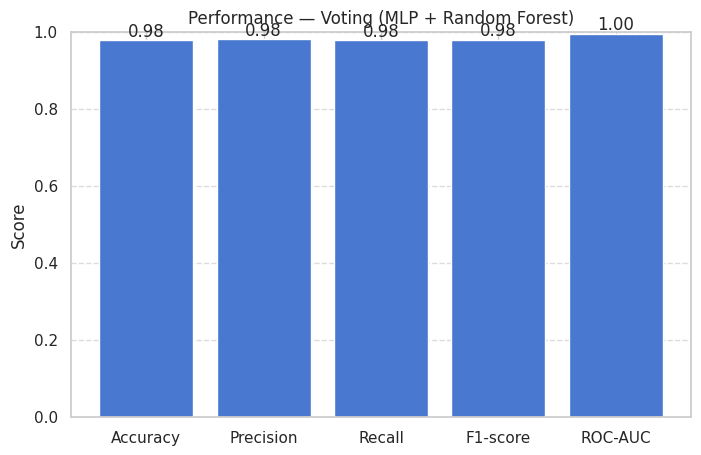

In [ ]:
# Display metrics for Voting (MLP + Random Forest)
print("\n=== Voting (MLP + Random Forest) Metrics ===")
for k,v in vote_mlp_rf_results.items():
    if k != "Model":
        print(f"{k:9s}: {v:.4f}")

# Confusion Matrix (counts + normalized)
y_pred = (y_prob >= 0.5).astype(int) # Recalculate pred from prob for CM display
cm_counts = confusion_matrix(y_test, y_pred)
cm_norm   = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm_counts).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix (Counts) — Voting MLP+RF")
ConfusionMatrixDisplay(cm_norm).plot(ax=ax[1], colorbar=False, values_format=".2f")
ax[1].set_title("Confusion Matrix (Normalized) — Voting MLP+RF")
plt.tight_layout(); plt.show()

# ROC + PR curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Voting MLP+RF")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall Curve — Voting MLP+RF")
plt.show()

# Bar chart of metrics
plt.figure(figsize=(8,5))
bars = plt.bar(["Accuracy","Precision","Recall","F1-score","ROC-AUC"],
               [vote_mlp_rf_results["Accuracy"], vote_mlp_rf_results["Precision"], vote_mlp_rf_results["Recall"], vote_mlp_rf_results["F1-score"], vote_mlp_rf_results["ROC-AUC"]])
plt.ylim(0,1)
plt.title("Performance — Voting (MLP + Random Forest)")
plt.ylabel("Score"); plt.grid(axis="y", linestyle="--", alpha=0.7)
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y+0.01, f"{y:.2f}", ha="center")
plt.show()

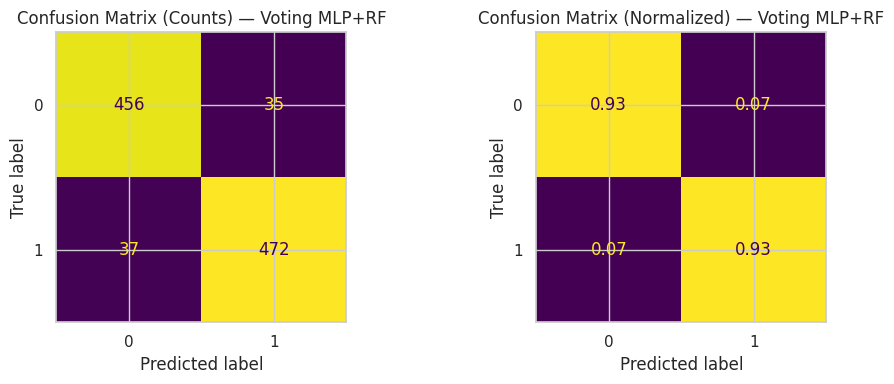

In [ ]:
# Confusion Matrix (counts + normalized)
y_pred = (y_prob >= 0.5).astype(int) # Recalculate pred from prob for CM display
cm_counts = confusion_matrix(y_test, y_pred)
cm_norm   = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm_counts).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix (Counts) — Voting MLP+RF")
ConfusionMatrixDisplay(cm_norm).plot(ax=ax[1], colorbar=False, values_format=".2f")
ax[1].set_title("Confusion Matrix (Normalized) — Voting MLP+RF")
plt.tight_layout(); plt.show()


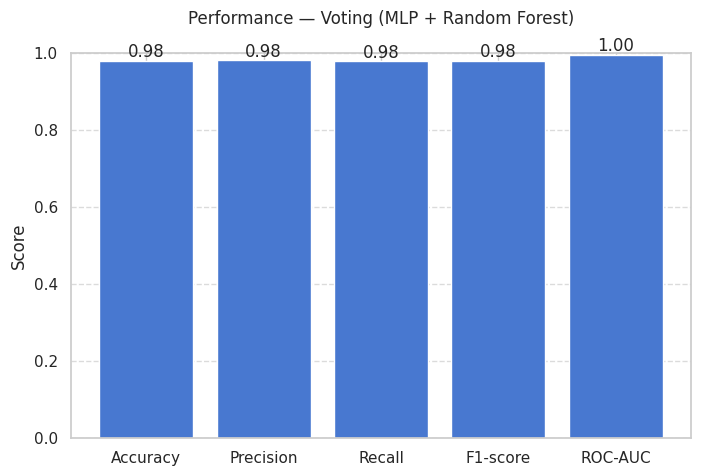

In [ ]:

# Bar chart of metrics
plt.figure(figsize=(8,5))
bars = plt.bar(["Accuracy","Precision","Recall","F1-score","ROC-AUC"],
               [vote_mlp_rf_results["Accuracy"], vote_mlp_rf_results["Precision"], vote_mlp_rf_results["Recall"], vote_mlp_rf_results["F1-score"], vote_mlp_rf_results["ROC-AUC"]])
plt.ylim(0,1)
plt.title("Performance — Voting (MLP + Random Forest)\n")
plt.ylabel("Score"); plt.grid(axis="y", linestyle="--", alpha=0.7)
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y+0.01, f"{y:.2f}", ha="center")
plt.show()

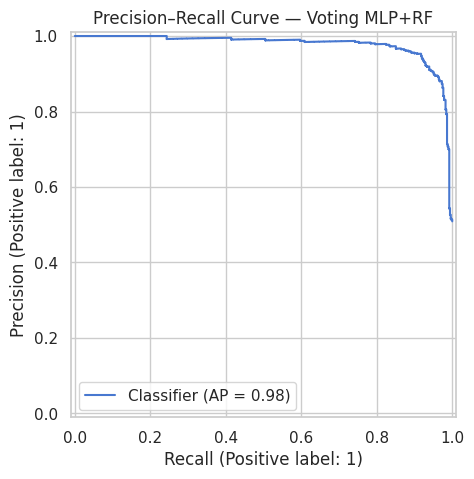

In [ ]:


PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall Curve — Voting MLP+RF")
plt.show()

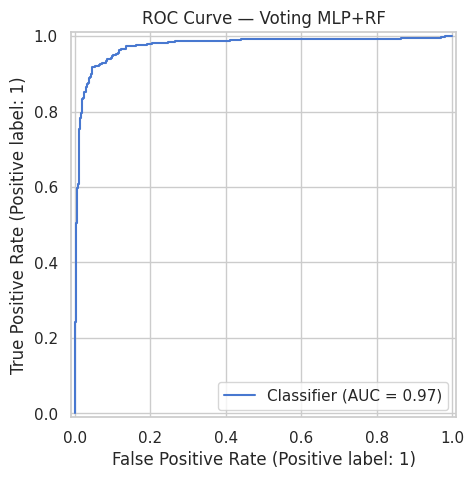

In [ ]:

# ROC + PR curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Voting MLP+RF")
plt.show()


In [ ]:
import joblib
import os


model_variable_name = 'vote_mlp_rf'
model_filename = 'liver_disease_model.joblib'

print(f"Attempting to save model '{model_variable_name}'...")

try:
    
    if model_variable_name in locals() or model_variable_name in globals():
        
        
        model_to_save = globals().get(model_variable_name, locals().get(model_variable_name))
        
        
        joblib.dump(model_to_save, model_filename)
        
        print("\n--- SUCCESS ---")
        print(f"Model successfully saved as '{model_filename}'")
        print(f"File path: {os.path.abspath(model_filename)}")
        print("---------------")
        
    else:
        
        print("\n--- ERROR ---")
        print(f"Error: Model variable '{model_variable_name}' not found.")
        print("Please run the notebook cells that define and train the 'vote_mlp_rf' model first.")
        print("---------------")

except Exception as e:
    print(f"\nAn error occurred while saving the model: {e}")